# Install Everything & Import Data

In [ ]:
!pip install -q  transformers==4.30.1 datasets evaluate thaixtransformers
!pip install peft==0.10.0
!pip install huggingface_hub
!pip install wandb
!pip install git+https://github.com/trent-b/iterative-stratification.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.6/113.6 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 3.4.1 r

In [ ]:
%matplotlib inline
import pandas
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from torch.utils.data import Dataset
from IPython.display import display
from collections import defaultdict
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jeerasakk","key":"74d3237099bc948f9edfe760b57bcc05"}'}

In [ ]:
import wandb
# wandb.login()

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c 2110446-dsde-2024-2

 97% 25.0M/25.8M [00:00<00:00, 67.0MB/s]
100% 25.8M/25.8M [00:00<00:00, 69.5MB/s]


In [ ]:
!unzip 2110446-dsde-2024-2.zip -d /content/dataset

Archive:  2110446-dsde-2024-2.zip
  inflating: /content/dataset/sample_submission.csv  
  inflating: /content/dataset/test.csv  
  inflating: /content/dataset/train.csv  


# Create&Pre-process Train DataSet

In [ ]:
data_df = pd.read_csv('/content/dataset/train.csv')

data_df.describe()

,id,สำนักงานตำรวจแห่งชาติ,การรถไฟฟ้าขนส่งมวลชนแห่งประเทศไทย,สภาเด็กและเยาวชนกรุงเทพมหานคร,กรมควบคุมมลพิษ,กรมสรรพสามิต,การไฟฟ้านครหลวง,กรมทางหลวง,สำนักงานประกันสุขภาพแห่งชาติ,การประปานครหลวง,คณะกรรมการการพัฒนาเศรษฐกิจ,กระทรวงการท่องเที่ยวและกีฬา,สำนักงาน กสทช. ศูนย์รับแจ้งปัญหา 1200
count,204622.000000,204622.000000,204622.000000,204622.000000,204622.000000,204622.000000,204622.000000,204622.000000,204622.000000,204622.000000,204622.000000,204622.000000,204622.000000
mean,102310.500000,0.209635,0.019969,0.000049,0.016034,0.000117,0.167944,0.034542,0.000406,0.024176,0.018478,0.000059,0.023839
std,59069.427728,0.407049,0.139892,0.006991,0.125608,0.010829,0.373817,0.182616,0.020136,0.153597,0.134672,0.007658,0.152548
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,51155.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,102310.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,153465.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,204621.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Clean Zero label & Some word

In [ ]:
#Zero label
print(data_df.iloc[:, 2:].sum(axis=1).eq(0).sum())

102333


In [ ]:
data_df["comment"] = data_df["comment"].str.strip()
data_df = data_df.drop_duplicates()
data_df = data_df.dropna(subset=["comment"])
data_df["comment"] = data_df["comment"].str.lower()
data_df["comment"] = data_df["comment"].str.replace("\n", " ")
data_df["comment"] = data_df["comment"].str.replace("\r", " ")
data_df["comment"] = data_df["comment"].str.replace("\t", " ")
zero_rows = data_df.iloc[:, 2:].sum(axis=1) == 0
rows_to_drop = data_df[zero_rows].sample(frac=0.5, random_state=42).index
data_df = data_df.drop(rows_to_drop).reset_index(drop=True)

In [ ]:
print(data_df.iloc[:, 2:].sum(axis=1).eq(0).sum())

51167


In [ ]:
data_df.describe()

,id,สำนักงานตำรวจแห่งชาติ,การรถไฟฟ้าขนส่งมวลชนแห่งประเทศไทย,สภาเด็กและเยาวชนกรุงเทพมหานคร,กรมควบคุมมลพิษ,กรมสรรพสามิต,การไฟฟ้านครหลวง,กรมทางหลวง,สำนักงานประกันสุขภาพแห่งชาติ,การประปานครหลวง,คณะกรรมการการพัฒนาเศรษฐกิจ,กระทรวงการท่องเที่ยวและกีฬา,สำนักงาน กสทช. ศูนย์รับแจ้งปัญหา 1200
count,153456.000000,153456.000000,153456.000000,153456.000000,153456.000000,153456.000000,153456.000000,153456.000000,153456.000000,153456.000000,153456.000000,153456.000000,153456.000000
mean,101036.679921,0.279533,0.026627,0.000065,0.021381,0.000156,0.223940,0.046059,0.000541,0.032237,0.024639,0.000078,0.031788
std,58564.141822,0.448771,0.160990,0.008072,0.144650,0.012505,0.416884,0.209613,0.023250,0.176630,0.155023,0.008843,0.175435
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50514.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,100792.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,151052.250000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,204620.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Clean over 256 tokens sentence

In [ ]:
data_df = data_df[data_df["comment"].str.split().apply(len) <= 256]

In [ ]:
data_df.describe()

,id,สำนักงานตำรวจแห่งชาติ,การรถไฟฟ้าขนส่งมวลชนแห่งประเทศไทย,สภาเด็กและเยาวชนกรุงเทพมหานคร,กรมควบคุมมลพิษ,กรมสรรพสามิต,การไฟฟ้านครหลวง,กรมทางหลวง,สำนักงานประกันสุขภาพแห่งชาติ,การประปานครหลวง,คณะกรรมการการพัฒนาเศรษฐกิจ,กระทรวงการท่องเที่ยวและกีฬา,สำนักงาน กสทช. ศูนย์รับแจ้งปัญหา 1200
count,153426.000000,153426.000000,153426.000000,153426.000000,153426.000000,153426.000000,153426.000000,153426.000000,153426.000000,153426.000000,153426.000000,153426.000000,153426.000000
mean,101045.222687,0.279575,0.026632,0.000065,0.021385,0.000156,0.223971,0.046068,0.000541,0.032244,0.024513,0.000078,0.031794
std,58561.402348,0.448792,0.161005,0.008073,0.144664,0.012506,0.416904,0.209633,0.023253,0.176647,0.154637,0.008844,0.175451
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50529.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,100803.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,151055.500000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,204620.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Clean emoji,url,wrong spell

In [ ]:
!pip install pythainlp emoji

In [ ]:
from pythainlp import word_tokenize
from pythainlp.util import normalize
import re, emoji, string
def replace_url(text):
    URL_PATTERN = r"""(?i)\b((?:https?:(?:/{1,3}|[a-z0-9%])|[a-z0-9.\-]+[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)/)(?:[^\s()<>{}\[\]]+|\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\))+(?:\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\)|[^\s!()\[\]{};:'".,<>?«»“”‘’])|(?:(?<!@)[a-z0-9]+(?:[.\-][a-z0-9]+)*[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)\b/?(?!@)))"""
    return re.sub(URL_PATTERN, '', text)

def replace_rep(text):
    return re.sub(r'(\S)\1{2,}', r'\1', text)

def remove_emoji(text):
    return ''.join(char for char in text if emoji.emoji_count(char) == 0)

def process_text(text):
    text = normalize(text).strip()

    text = replace_url(text)

    text = remove_emoji(text)

    text = replace_rep(text)

    text = ''.join(char for char in text if char not in string.punctuation)

    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [ ]:
#try
example_text = "1. เรื่อง : การจัดการพื้นที่ที่อยู่ในระหว่างปรับปรุง/ก่อสร้าง เพื่อความปลอดภัย เนื่องจากบริเวณถนนวิภาวดีตั้งแต่ช่วงประมาณซอยวิภาวดี 5 บริเวณช่วงหน้าสำนักข่าวไทยรัฐมีการปรับปรุงทางเท้า ซึ่งอยู่ในระหว่างก่อสร้าง แต่พบว่าไม่มีการกั้นและทำทางเดินชั่วคราวให้ชัดเจน การติดสัญญาณไฟ และป้ายบอกทางที่ใกล้จะร่วง ลมแรงป้ายก็จะขยับมีโอกาสร่วงหล่นใส่ประชาชนได้  ตำแหน่ง dropped pin https://goo.gl/maps/qxumrsbhzjr6cyzk8"
print(process_text(example_text))
print("")
example_text = "ถ.ประชาราษฎร์สาย 1 มีบ่อที่เปิดดำเนินการขนาดใหญ่กลางถนนจำนวนหลายบ่อ และฝาบ่อกับพื้นผิวถนนมีระดับที่ต่างกัน รถวิ่งผ่านทุกวันช่วงล่างพังหมดค่าาาาา 😒😒"
print(process_text(example_text))
print("")
example_text = "--- ตลาดบริเวณแยกพรานนก ริมถนนอิสรภาพ มีผู้ค้าขายเต็มฟุตบาท และมีรถยนต์ รถจักรยานยนต์ ทั้งผู้ค้าผู้ซื้อ รถรับจ้าง จอด ทำให้การจราจรติดขัดเป็นอย่างมาก ช่วยพิจารณาแก้ไขด้วยครับ"
print("")
print(process_text(example_text))
example_text = "ๅ/-ภๅ/12345 17:30 - 15.30เทสครับบบบบครับ สะกดผิก"
print("")
print(process_text(example_text))

1 เรื่อง การจัดการพื้นที่ที่อยู่ในระหว่างปรับปรุงก่อสร้าง เพื่อความปลอดภัย เนื่องจากบริเวณถนนวิภาวดีตั้งแต่ช่วงประมาณซอยวิภาวดี 5 บริเวณช่วงหน้าสำนักข่าวไทยรัฐมีการปรับปรุงทางเท้า ซึ่งอยู่ในระหว่างก่อสร้าง แต่พบว่าไม่มีการกั้นและทำทางเดินชั่วคราวให้ชัดเจน การติดสัญญาณไฟ และป้ายบอกทางที่ใกล้จะร่วง ลมแรงป้ายก็จะขยับมีโอกาสร่วงหล่นใส่ประชาชนได้ ตำแหน่ง dropped pin

ถประชาราษฎร์สาย 1 มีบ่อที่เปิดดำเนินการขนาดใหญ่กลางถนนจำนวนหลายบ่อ และฝาบ่อกับพื้นผิวถนนมีระดับที่ต่างกัน รถวิ่งผ่านทุกวันช่วงล่างพังหมดค่า


ตลาดบริเวณแยกพรานนก ริมถนนอิสรภาพ มีผู้ค้าขายเต็มฟุตบาท และมีรถยนต์ รถจักรยานยนต์ ทั้งผู้ค้าผู้ซื้อ รถรับจ้าง จอด ทำให้การจราจรติดขัดเป็นอย่างมาก ช่วยพิจารณาแก้ไขด้วยครับ

ๅภา12345 1730 1530เทสครับครับ สะกดผิก


In [ ]:
#Apply
data_df["comment"] = data_df["comment"].apply(process_text)

In [ ]:
print(data_df['comment'][2743])
print("")
print(data_df['comment'][2756])
print("")
print(data_df['comment'][3043])
print("")
print(data_df['comment'][3044])

ฝาท่อระบายน้ำริมถนนใกล้ footpath แตก ทำให้ไม่สะดวกในการเดิน

ป้ายหาเสียง ผู้ว่าสก ยังไม่ยอมมาเก็บค่ะ ซอยพัฒนาการ 74 เส้นพัฒนาการขาเข้าจากถนนอ่อนนุช เส้นพัฒนาการขาออกตัดกับแยกอ่อนนุชลาดกระบัง

ทำทางมีเกิน 1 ปีแล้วค่ะ ไม่มีป้ายแจ้งว่าเสร็จเมื่อไหร่ โครงการอะไร เวลาเดินทางเท้าถ้าช่วงฝนตกต้องลง ถนนค่ะ ทำให้อันตรายมาก เพราะเป็นทางเดียวกับรถขับผ่าน

ถนนเชื่อมสัมพันธ์ตลอดสายมีถังขยะไม่เพียงพอครับ ขอถังขยะหน่อย


In [ ]:
#Clean ค่ะ&ครับ
data_df["comment"] = data_df["comment"].str.replace("ค่ะ", "")
data_df["comment"] = data_df["comment"].str.replace("ครับ", "")
data_df["comment"] = data_df["comment"].str.strip()

In [ ]:
print(data_df['comment'][2743])
print("")
print(data_df['comment'][2756])
print("")
print(data_df['comment'][3043])
print("")
print(data_df['comment'][3044])

ฝาท่อระบายน้ำริมถนนใกล้ footpath แตก ทำให้ไม่สะดวกในการเดิน

ป้ายหาเสียง ผู้ว่าสก ยังไม่ยอมมาเก็บ ซอยพัฒนาการ 74 เส้นพัฒนาการขาเข้าจากถนนอ่อนนุช เส้นพัฒนาการขาออกตัดกับแยกอ่อนนุชลาดกระบัง

ทำทางมีเกิน 1 ปีแล้ว ไม่มีป้ายแจ้งว่าเสร็จเมื่อไหร่ โครงการอะไร เวลาเดินทางเท้าถ้าช่วงฝนตกต้องลง ถนน ทำให้อันตรายมาก เพราะเป็นทางเดียวกับรถขับผ่าน

ถนนเชื่อมสัมพันธ์ตลอดสายมีถังขยะไม่เพียงพอ ขอถังขยะหน่อย


## Remove Duplicate

In [ ]:
!pip install datasketch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 kB 3.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from datasketch import MinHash, MinHashLSH

def get_minhash(text, num_perm=256):
    """Convert text into MinHash signature"""
    m = MinHash(num_perm=num_perm)
    for word in set(text.split()):
        m.update(word.encode('utf8'))
    return m

def remove_similar_comments_lsh(df, threshold=0.8, num_perm=256):
    """Remove similar comments using MinHash + LSH"""
    lsh = MinHashLSH(threshold=threshold, num_perm=num_perm)
    minhashes = {}

    to_remove = set()

    for i, row in df.iterrows():
        minhash = get_minhash(row["comment"], num_perm)
        minhashes[i] = minhash

        for j in lsh.query(minhash):
            to_remove.add(j)

        lsh.insert(i, minhash)

    df_cleaned = df.drop(index=list(to_remove)).reset_index(drop=True)
    return df_cleaned

In [ ]:
data_df = remove_similar_comments_lsh(data_df, threshold=0.8)

In [ ]:
data_df.describe()

,id,สำนักงานตำรวจแห่งชาติ,การรถไฟฟ้าขนส่งมวลชนแห่งประเทศไทย,สภาเด็กและเยาวชนกรุงเทพมหานคร,กรมควบคุมมลพิษ,กรมสรรพสามิต,การไฟฟ้านครหลวง,กรมทางหลวง,สำนักงานประกันสุขภาพแห่งชาติ,การประปานครหลวง,คณะกรรมการการพัฒนาเศรษฐกิจ,กระทรวงการท่องเที่ยวและกีฬา,สำนักงาน กสทช. ศูนย์รับแจ้งปัญหา 1200
count,150735.000000,150735.000000,150735.000000,150735.000000,150735.000000,150735.000000,150735.000000,150735.000000,150735.000000,150735.000000,150735.000000,150735.000000,150735.000000
mean,101024.912661,0.275198,0.026908,0.000066,0.021561,0.000159,0.225276,0.046280,0.000537,0.032474,0.024659,0.000080,0.032176
std,58606.158377,0.446616,0.161816,0.008145,0.145246,0.012617,0.417765,0.210091,0.023175,0.177256,0.155085,0.008922,0.176467
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50519.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,100725.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,151078.500000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,204620.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Train-Val Split

In [ ]:
from torch.utils.data import Dataset, DataLoader
from thaixtransformers import Tokenizer
from transformers import DataCollatorWithPadding, AutoModel
from tqdm import tqdm

In [ ]:
tokenizer = Tokenizer("airesearch/wangchanberta-base-att-spm-uncased")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


sentencepiece.bpe.model:   0%|          | 0.00/905k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/282 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/546 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'CamembertTokenizer'. 
The class this function is called from is 'WangchanbertaTokenizer'.


In [ ]:
!pip install git+https://github.com/trent-b/iterative-stratification.git

  Cloning https://github.com/trent-b/iterative-stratification.git to /tmp/pip-req-build-diwsoqew
  Running command git clone --filter=blob:none --quiet https://github.com/trent-b/iterative-stratification.git /tmp/pip-req-build-diwsoqew
  Resolved https://github.com/trent-b/iterative-stratification.git to commit c763bd5440e5f03c6447471305897c1046fc4838
  Preparing metadata (setup.py) ... done


In [ ]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import pandas as pd
import numpy as np

X = data_df.iloc[:, 1]
y = data_df.iloc[:, 2:]

mssk = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)

train_idx, val_idx = next(mssk.split(X, y))

train_df = data_df.iloc[train_idx].reset_index(drop=True)
val_df = data_df.iloc[val_idx].reset_index(drop=True)

X_train = train_df.iloc[:, 1].apply(lambda text: tokenizer(text.replace('ํา', "ำ"))).to_numpy()
y_train = train_df.iloc[:, 2:].to_numpy()

X_val = val_df.iloc[:, 1].apply(lambda text: tokenizer(text.replace('ํา', "ำ"))).to_numpy()
y_val = val_df.iloc[:, 2:].to_numpy()

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(120588,) (120588, 12) (30147,) (30147, 12)


# Augment Data

## Plot Data and consider class to add

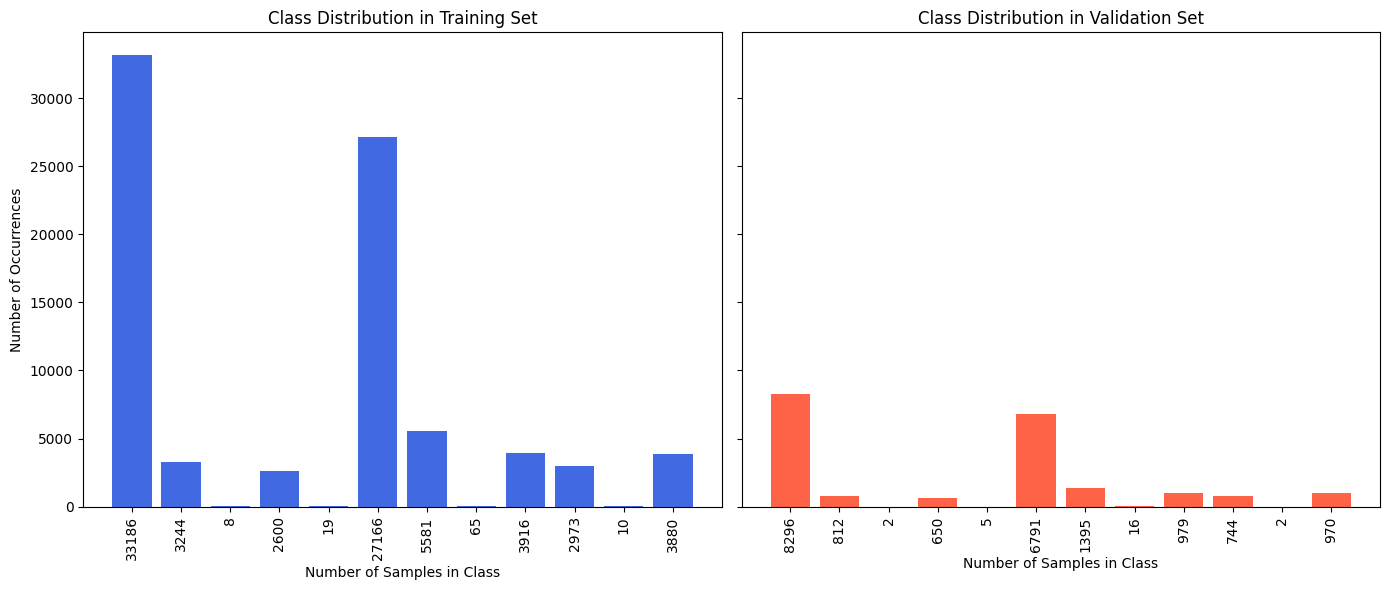

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class_labels = data_df.columns[2:]

train_class_counts = y_train.sum(axis=0)
val_class_counts = y_val.sum(axis=0)

x_train = np.arange(len(class_labels))
x_val = np.arange(len(class_labels))

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

axes[0].bar(x_train, train_class_counts, color='royalblue')
axes[0].set_xticks(x_train)
axes[0].set_xticklabels(train_class_counts, rotation=90)
axes[0].set_xlabel("Number of Samples in Class")
axes[0].set_ylabel("Number of Occurrences")
axes[0].set_title("Class Distribution in Training Set")

axes[1].bar(x_val, val_class_counts, color='tomato')
axes[1].set_xticks(x_val)
axes[1].set_xticklabels(val_class_counts, rotation=90)
axes[1].set_xlabel("Number of Samples in Class")
axes[1].set_title("Class Distribution in Validation Set")

plt.tight_layout()
plt.show()

In [ ]:
label_names = train_df.columns[2:]
class_indices = [2, 4, 7, 10]
for class_index in class_indices:
    selected_label = label_names[class_index]
    filtered_df = train_df[train_df[selected_label] == 1]

    print(f"{selected_label}:\n")

    for idx, comment in enumerate(filtered_df["comment"]):
        print(f"{idx+1}: {comment}")
    print("")

สภาเด็กและเยาวชนกรุงเทพมหานคร:

1: ถนนบริเวณนั้นเป็นหลุม ข้างในลักษณะเป็นโพร่ง ซึ่งเด็กและเยาวชนที่ขี่มอเตอร์ไซค์อาจได้รับอันตราย โดยเฉพาะตอนกลางคืนที่บริเวณนั้นไม่ค่อยสว่างด้วย
2: พบแม่ พาลูกมาขอทาน เด็ก3เดือน ที่บริเวณตลาดนัดธนะสิน ซอย นวมินทร์ 68 ตามที่สอบถามวันนี้ แจ้งว่าจะมาอีกทีวันอาทิตย์ที่ 12 พคเวลา 1700 นอยากให้หน่วยงานเข้าช่วยเหลือ เนื่องจากไม่แน่ใจว่าเป็นกลุ่มค้ามนุษย์หรือไม่ หากไม่ใช่ กรุณาให้ความช่วยเหลือแม่และเด็กด้วย
3: มีเด็กเล็กนั่งขอทานอยู่ที่ตีนสะพานลอยข้าง exchange tower กลัวจะเป็นกระบวนการลักพาตัวเด็ก
4: เรียน อาจารย์ชัชชาติ สิทธิ์พันธุ์ กระผม มีเรื่องจะสอบถาม มีข้าราชการคนนึง ได้มีการลงอบรมซ้ำซ้อน อยากสอบถามว่า ถ้ามีการอบรม สามารถลงชื่อซ้ำซ้อนได้หรือไม่ ถ้าลงได้ จะไม่เป็นการเอาเปรียบผู้เข้าอบรมคนอื่นๆหรอ
5: สอบถามเรื่องการรับเด็กต่างด้าว ที่เกิดในไทย เข้าเรียน โรงเรียนสังกัด กทม เนื่องจากมีเด็กต่างด้าว เกิดในไทย อายุ 8 ปี แต่ไม่เคยเข้าเรียนเลย เนื่องผู้ปกครองชาวกะเหรี่ยง มีใบอนุญาต ไม่มีความสามารถในการส่งเสียเข้าเรียน เด็กพูดไทยได้น้อยมาก อ่านเขียนไม่ได้ เด็กต้องก

## New Data

In [ ]:
new_2 = [
    "พื้นถนนบริเวณดังกล่าวเป็นหลุมลึกและอาจเป็นอันตรายต่อเด็กและเยาวชนที่ใช้รถจักรยานยนต์ โดยเฉพาะตอนกลางคืนที่มีแสงสว่างไม่เพียงพอ",
    "พบหญิงสาวอุ้มลูกวัยสามเดือนขอทานบริเวณตลาดนัดธนะสิน ซอยนวมินทร์ 68 ซึ่งเธอแจ้งว่าจะกลับมาอีกครั้งในวันที่ 12 พฤษภาคม เวลา 17:00 น. ขอให้หน่วยงานที่เกี่ยวข้องช่วยตรวจสอบและให้ความช่วยเหลือ",
    "มีเด็กเล็กนั่งขอทานบริเวณสะพานลอยใกล้ Exchange Tower หวั่นว่าอาจเกี่ยวข้องกับขบวนการค้ามนุษย์",
    "ต้องการสอบถามเกี่ยวกับการรับเด็กที่เกิดในประเทศไทยแต่เป็นชาวต่างด้าวเข้าเรียนในโรงเรียนสังกัด กทม. เด็กอายุ 8 ปี ไม่มีพื้นฐานการศึกษาและต้องการเข้าเรียน",
    "ในซอยนี้มีรถขับด้วยความเร็วสูง ซึ่งอาจเป็นอันตรายต่อเด็กที่ขี่จักรยาน ขอให้ติดตั้งป้ายจำกัดความเร็วในเขตชุมชน",
    "โรงงานแห่งหนึ่งสร้างมลภาวะทางเสียงและฝุ่นละอองต่อเนื่อง ส่งผลกระทบต่อเด็กในพื้นที่ที่ไม่สามารถพักผ่อนได้อย่างเต็มที่",
    "มีกลุ่มวัยรุ่นรวมตัวมั่วสุมที่บริเวณบ้านร้างในสวนสาธารณะริมบึงแก้มลิง ขอให้เพิ่มมาตรการรักษาความปลอดภัยในพื้นที่",
    "พบกลุ่มนักเรียนมั่วสุม สูบบุหรี่ไฟฟ้า และรีดไถเงินเพื่อนที่ซอยวัชรพล 3 และในร้านสะดวกซื้อ โดยไม่มีครูคอยดูแล",
    "ถนนบริเวณนี้ชำรุดเป็นหลุมบ่อ ทำให้การเดินทางลำบากและเพิ่มความเสี่ยงต่ออุบัติเหตุ",
    "พบแม่ลูกอ่อนนั่งขอทานในตลาด ต้องการให้หน่วยงานที่เกี่ยวข้องเข้าตรวจสอบเพื่อให้ความช่วยเหลือ",
    "มีเด็กเร่ร่อนนั่งขอทานใกล้สะพานลอย อาจเสี่ยงต่อการถูกล่อลวงหรือเป็นเหยื่อของขบวนการค้ามนุษย์",
    "ขอสอบถามเกี่ยวกับสิทธิของเด็กต่างด้าวที่เกิดในประเทศไทยในการเข้าเรียนโรงเรียนของรัฐ",
    "ถนนสายนี้มีรถวิ่งด้วยความเร็วสูง ส่งผลให้เด็กและคนเดินเท้าต้องเผชิญกับอันตราย",
    "โรงงานส่งเสียงดังและปล่อยฝุ่นตลอดทั้งวัน ทำให้ชุมชนได้รับผลกระทบหนัก",
    "สวนสาธารณะบริเวณริมบึงกลายเป็นแหล่งมั่วสุมของวัยรุ่น ควรมีเจ้าหน้าที่รักษาความปลอดภัยดูแล",
    "มีการรวมกลุ่มของวัยรุ่นในพื้นที่โรงเรียน สูบบุหรี่ไฟฟ้าและสร้างความวุ่นวาย ต้องการให้ครูเข้ามาตรวจสอบ",
    "ถนนมีหลุมขนาดใหญ่ เสี่ยงต่ออุบัติเหตุโดยเฉพาะช่วงกลางคืนที่มีแสงสว่างไม่เพียงพอ",
    "พบเด็กขอทานบริเวณตลาดนัด อาจอยู่ในสภาวะเสี่ยงต่อการถูกแสวงหาประโยชน์",
    "มีเด็กจำนวนมากอยู่ในจุดเสี่ยงที่อาจเป็นเป้าหมายของการค้ามนุษย์ ควรมีมาตรการเฝ้าระวัง",
    "โรงเรียนสามารถเปิดรับเด็กต่างด้าวเข้าเรียนได้หรือไม่ หากเด็กไม่มีพื้นฐานทางภาษา",
    "การจราจรในซอยนี้เป็นอันตรายต่อเด็กเล็กที่เดินทางไปโรงเรียน ควรมีมาตรการควบคุมความเร็ว",
    "โรงงานสร้างผลกระทบต่อสุขภาพของชาวบ้าน โดยเฉพาะเด็กที่ต้องสูดฝุ่นตลอดเวลา",
    "มีเด็กวัยรุ่นรวมตัวในพื้นที่เปลี่ยวและมีพฤติกรรมเสี่ยง ควรมีการดูแลจากเจ้าหน้าที่",
    "ขอให้มีมาตรการเพิ่มความปลอดภัยบริเวณโรงเรียน เนื่องจากพบพฤติกรรมไม่เหมาะสมของกลุ่มนักเรียน",
    "ถนนทรุดโทรมหนัก ทำให้ผู้ใช้รถใช้ถนนต้องเผชิญกับความเสี่ยงอุบัติเหตุ",
    "พบแม่อุ้มลูกขอทานหลายครั้ง ควรมีหน่วยงานเข้าช่วยเหลือเพื่อป้องกันอันตราย",
    "มีการรวมตัวของวัยรุ่นในสถานที่เปลี่ยว ควรเพิ่มแสงสว่างและจัดเวรยามรักษาความปลอดภัย",
    "โรงเรียนมีมาตรการดูแลเด็กที่มีปัญหาทางพฤติกรรมหรือไม่ ควรมีการตรวจสอบเพิ่มเติม",
    "ถนนสายนี้มีอุบัติเหตุบ่อยครั้งเนื่องจากสภาพถนนที่ไม่เรียบ ขอให้มีการซ่อมแซม",
    "ขอให้มีมาตรการควบคุมรถที่ใช้ความเร็วสูงในเขตชุมชนเพื่อความปลอดภัยของเด็กและประชาชน",
    "พื้นถนนบริเวณดังกล่าวเป็นหลุมลึกและอาจเป็นอันตรายต่อเด็กและเยาวชนที่ใช้รถจักรยานยนต์ โดยเฉพาะตอนกลางคืนที่มีแสงสว่างไม่เพียงพอ ทำให้ผู้ขับขี่มองไม่เห็นหลุมและอาจเกิดอุบัติเหตุร้ายแรงได้",
    "พบหญิงสาวอุ้มลูกวัยสามเดือนขอทานบริเวณตลาดนัดธนะสิน ซอยนวมินทร์ 68 ซึ่งเธอแจ้งว่าจะกลับมาอีกครั้งในวันที่ 12 พฤษภาคม เวลา 17:00 น. ขอให้หน่วยงานที่เกี่ยวข้องช่วยตรวจสอบและให้ความช่วยเหลือ เนื่องจากอาจเป็นกลุ่มค้ามนุษย์หรือไม่",
    "มีเด็กเล็กนั่งขอทานบริเวณสะพานลอยใกล้ Exchange Tower หวั่นว่าอาจเกี่ยวข้องกับขบวนการค้ามนุษย์ หากปล่อยไว้โดยไม่มีการตรวจสอบอาจเสี่ยงต่อความปลอดภัยของเด็กและคนที่ผ่านไปมา",
    "ต้องการสอบถามเกี่ยวกับการรับเด็กที่เกิดในประเทศไทยแต่เป็นชาวต่างด้าวเข้าเรียนในโรงเรียนสังกัด กทม. เด็กอายุ 8 ปี ไม่มีพื้นฐานการศึกษาและต้องการเข้าเรียน โดยผู้ปกครองมีความประสงค์ให้เด็กได้รับการศึกษาที่เหมาะสม",
    "ในซอยนี้มีรถขับด้วยความเร็วสูง ซึ่งอาจเป็นอันตรายต่อเด็กที่ขี่จักรยาน รวมถึงผู้สูงอายุที่เดินสัญจรในละแวกนี้ ขอให้ติดตั้งป้ายจำกัดความเร็วในเขตชุมชนเพื่อลดอุบัติเหตุ",
    "โรงงานแห่งหนึ่งสร้างมลภาวะทางเสียงและฝุ่นละอองต่อเนื่อง ส่งผลกระทบต่อเด็กในพื้นที่ที่ไม่สามารถพักผ่อนได้อย่างเต็มที่ โดยเฉพาะช่วงเวลากลางคืน ทำให้ผู้ปกครองเป็นกังวลถึงสุขภาพของเด็ก",
    "มีกลุ่มวัยรุ่นรวมตัวมั่วสุมที่บริเวณบ้านร้างในสวนสาธารณะริมบึงแก้มลิง ขอให้เพิ่มมาตรการรักษาความปลอดภัยในพื้นที่ รวมถึงการจัดเจ้าหน้าที่ดูแลเพื่อป้องกันพฤติกรรมเสี่ยงที่อาจเกิดขึ้น",
    "พบกลุ่มนักเรียนมั่วสุม สูบบุหรี่ไฟฟ้า และรีดไถเงินเพื่อนที่ซอยวัชรพล 3 และในร้านสะดวกซื้อ โดยไม่มีครูคอยดูแล ซึ่งอาจเป็นอันตรายและส่งผลเสียต่อพฤติกรรมของนักเรียนกลุ่มอื่น",
    "ถนนบริเวณนี้ชำรุดเป็นหลุมบ่อ ทำให้การเดินทางลำบากและเพิ่มความเสี่ยงต่ออุบัติเหตุ โดยเฉพาะในช่วงเวลากลางคืนที่มีแสงสว่างไม่เพียงพอ อาจทำให้ผู้ขับขี่ตกหลุมเสียหลักได้",
    "พบแม่ลูกอ่อนนั่งขอทานในตลาด ต้องการให้หน่วยงานที่เกี่ยวข้องเข้าตรวจสอบเพื่อให้ความช่วยเหลือ และป้องกันไม่ให้เด็กต้องตกอยู่ในสภาวะเสี่ยงต่อการถูกล่อลวงหรือแสวงหาผลประโยชน์",
    "มีเด็กเร่ร่อนนั่งขอทานใกล้สะพานลอย อาจเสี่ยงต่อการถูกล่อลวงหรือเป็นเหยื่อของขบวนการค้ามนุษย์ ซึ่งควรมีการตรวจสอบอย่างเร่งด่วนเพื่อป้องกันเหตุการณ์ไม่พึงประสงค์",
    "ขอสอบถามเกี่ยวกับสิทธิของเด็กต่างด้าวที่เกิดในประเทศไทยในการเข้าเรียนโรงเรียนของรัฐ เนื่องจากเด็กไม่สามารถเข้าเรียนได้เนื่องจากไม่มีเอกสารรับรองทางการศึกษา",
    "ถนนบริเวณนั้นเป็นหลุม ข้างในลักษณะเป็นโพร่ง ซึ่งเด็กและเยาวชนที่ขี่มอเตอร์ไซค์อาจได้รับอันตราย โดยเฉพาะตอนกลางคืนที่บริเวณนั้นไม่ค่อยสว่างด้วย",
    "พบแม่พาลูกมาขอทาน เด็ก 3 เดือน ที่บริเวณตลาดนัดธนะสิน ซอยนวมินทร์ 68 ตามที่สอบถามวันนี้ แจ้งว่าจะมาอีกทีวันอาทิตย์ที่ 12 พ.ค. เวลา 17:00 น. อยากให้หน่วยงานเข้าช่วยเหลือ เนื่องจากไม่แน่ใจว่าเป็นกลุ่มค้ามนุษย์หรือไม่ หากไม่ใช่ กรุณาให้ความช่วยเหลือแม่และเด็กด้วย",
    "มีเด็กเล็กนั่งขอทานอยู่ที่ตีนสะพานลอยข้าง Exchange Tower กลัวจะเป็นกระบวนการลักพาตัวเด็ก",
    "เรียน อาจารย์ชัชชาติ สิทธิพันธุ์ กระผมมีเรื่องจะสอบถาม มีข้าราชการคนหนึ่ง ได้มีการลงอบรมซ้ำซ้อน อยากสอบถามว่า ถ้ามีการอบรม สามารถลงชื่อซ้ำซ้อนได้หรือไม่ ถ้าลงได้ จะไม่เป็นการเอาเปรียบผู้เข้าอบรมคนอื่นๆ หรือไม่",
    "สอบถามเรื่องการรับเด็กต่างด้าวที่เกิดในไทยเข้าเรียนโรงเรียนสังกัด กทม. เนื่องจากมีเด็กต่างด้าวเกิดในไทย อายุ 8 ปี แต่ไม่เคยเข้าเรียนเลย เนื่องจากผู้ปกครองชาวกะเหรี่ยงมีใบอนุญาต แต่ไม่มีความสามารถในการส่งเสียเข้าเรียน เด็กพูดไทยได้น้อยมาก อ่านเขียนไม่ได้ ต้องการเข้าเรียนในโรงเรียนสังกัด กทม. แต่ไม่สามารถสมัครเรียนได้ เด็กสามารถสมัครเรียนได้ที่ไหนบ้าง หากอายุ 8 ปีแล้ว จะต้องเข้าเรียนชั้นไหน และสามารถซ้ำชั้นเพื่อให้ตามทันได้หรือไม่",
    "เด็กและผู้ปกครองได้รับความเดือดร้อนจากโรงงานนี้ ทั้งเสียงดัง ทั้งมีฝุ่นและแรงสั่นสะเทือนต่อเนื่องมาหลายเดือน เด็กไม่สามารถพักผ่อนได้ แม้ป่วยโควิดก็พักผ่อนไม่ได้ เดือดร้อนมากๆ สำนักงานเขตสะพานสูงก็ไม่สามารถดำเนินการให้หยุดได้",
    "ตรงช่วงบ้านร้างของสวนสาธารณะริมบึงแก้มลิงของ กทม. ท้ายซอยนวมินทร์ 24 แยกอุเทน 1820 ช่วงบ่ายเย็นของเกือบทุกวัน มีกลุ่มวัยรุ่นเด็กๆ ทั้งขี่มอเตอร์ไซค์เข้ามาจอดรวมกัน มาสูบบุหรี่ ทิ้งขยะ ฯลฯ มานั่งรวมกลุ่มมั่วสุม สร้างความรำคาญแก่คนที่มาออกกำลังกาย อยากให้มี รปภ. มาประจำฝั่งสวนด้านนี้บ้าง จะได้ไม่เป็นแหล่งมั่วสุมใหม่",
    "ถนนชำรุดอย่างหนัก ทำให้เด็กและเยาวชนที่อยู่ใกล้มหาวิทยาลัยเกิดอุบัติเหตุ"
]
new_2*=(1000//50)
len(new_2)

1000

In [ ]:
new_4 = [
    "ร้านเหล้าในพื้นที่ใกล้สถานศึกษาและชุมชน เปิดเพลงเสียงดังเกินกฎหมาย เปิดแบบแอบๆ และมีชาวต่างชาติก่อความเดือดร้อน",
    "ร้านเหล้าเปิดเพลงเสียงดังตลอดคืน มีการแจ้งเรื่องไปยัง สน.ตลาดพลูหลายครั้ง แต่ไม่มีเจ้าหน้าที่เข้ามาดำเนินการ",
    "ร้านเหล้าเถื่อนไม่มีใบอนุญาตเปิดในพื้นที่ชุมชน ใกล้หอพักและบ้านเรือนประชาชน ทางเขตแจ้งว่าส่งเรื่องไปทาง สน.คลองตันและสรรพสามิตแล้ว แต่ยังไม่มีการดำเนินการ",
    "เพื่อนบ้านขายสุรา เปิดเพลงเสียงดัง ปัสสาวะ และอ้วกหน้าบ้านผู้ร้อง",
    "ร้านขายสุราและเบียร์โดยไม่มีใบอนุญาต เปิดใกล้สถานศึกษา เปิดนั่งดื่มบนทางเท้าเกินเวลาจนถึงตีห้า",
    "ร้านจำหน่ายเครื่องดื่มแอลกอฮอล์โดยไม่ได้รับอนุญาต กินเหล้า เปิดเพลงเสียงดัง ปัสสาวะ และอ้วกหน้าบ้านผู้ร้อง",
    "ร้านขายสุราโดยไม่ได้รับอนุญาต มีการใช้เครื่องเสียงเสียงดังกระทบกระเทือนจนกระจกหอสั่น",
    "ร้านคาราโอเกะส่งเสียงดัง จำหน่ายสุราเกินเวลา มีเหตุทะเลาะวิวาทบ่อยครั้ง",
    "ร้านเปิดการแสดงรับชมนักร้องทำให้ส่งเสียงดังต่อแก่ประชาชนรอบข้าง",
    "บาร์เบียร์ชื่อร้านแบล็คบีชเปิดเพลงเสียงดังตั้งแต่ 17:00 น. ถึง 23:00 น. ทำให้ผู้พักอาศัยในคอนโดเดือดร้อน",
    "ร้านของชำจำหน่ายสุรา เปิดเพลงเสียงดังถึงเที่ยงคืนตีหนึ่ง บางวันก็มีจัดดนตรีมาแสดงด้วยพร้อมกับมีการตะโกนร้องกันเป็นกลุ่ม โดยใช้เครื่องขยายเสียง",
    "ร้านชงกันจัง เปิดเพลงเสียงดังรบกวน ช่วงเวลา 22:00 น. จนถึง 02:00 น. และทำการจำหน่ายสุรา จนถึงตอนเช้า ตั้งอยู่ใกล้กับสถานศึกษา",
    "ร้านขายสุราโดยไม่ได้รับอนุญาต มีการขอใบอนุญาตในการขายหรือไม่ มีการจ่ายป้ายภาษีของร้านไหม ป้ายโฆษณาร้านเยอะมาก และทางร้านได้มีการจ้างแรงงานเถื่อนหรือแรงงานผิดกฎหมายหรือไม่",
    "ร้าน helter sketer ปากซอยอินทามระ 4 ใกล้โรงเรียนอนุบาลเบญจมาศและโรงเรียน รุจิเสรีวิทยา นำใบอนุญาตของที่ตั้งร้านเดิมมาติดแอบอ้างไว้หน้าร้าน",
    "ร้านขายของชำมีการขอใบอนุญาตในการจำหน่ายสุรา บุหรี่ เบียร์ ถูกต้องตามกฎหมายหรือไม่",
    "ร้านแผงลอยร้านอาหาร ร้านยาดอง เปิดเพลงเสียงดังสวนมาก5ทุ่มถึง ตี4 เช้าบางเวลา",
    "ร้านจำหน่ายยาดองส่งเสียงดังรบกวน เป็นประจำทุกวัน และปิดร้านดึกทุกวัน ช่วงเวลา 03:00-04:00 น.",
    "ร้านบุหรี่หนีภาษีแอบขายอยู่ใจกลางเมืองตลาดวิลล่ามาเก็ต ซึ่งขายให้เยาวชนต่ำกว่า18ปี",
    "ร้านขายแมสตรงปากทางเข้าตลาดเกรียงไกร ตั้งร้านกีดขวางทั้งถนนและทางเท้า และมีการลักลอบค้าบุหรี่หนีภาษี",
    "พื้นถนนบริเวณดังกล่าวเป็นหลุมลึกและอาจเป็นอันตรายต่อเด็กและเยาวชนที่ใช้รถจักรยานยนต์ โดยเฉพาะตอนกลางคืนที่มีแสงสว่างไม่เพียงพอ",
    "พบหญิงสาวอุ้มลูกวัยสามเดือนขอทานบริเวณตลาดนัดธนะสิน ซอยนวมินทร์ 68 ซึ่งเธอแจ้งว่าจะกลับมาอีกครั้งในวันที่ 12 พฤษภาคม เวลา 17:00 น. ขอให้หน่วยงานที่เกี่ยวข้องช่วยตรวจสอบและให้ความช่วยเหลือ",
    "มีเด็กเล็กนั่งขอทานบริเวณสะพานลอยใกล้ Exchange Tower หวั่นว่าอาจเกี่ยวข้องกับขบวนการค้ามนุษย์",
    "ต้องการสอบถามเกี่ยวกับการรับเด็กที่เกิดในประเทศไทยแต่เป็นชาวต่างด้าวเข้าเรียนในโรงเรียนสังกัด กทม. เด็กอายุ 8 ปี ไม่มีพื้นฐานการศึกษาและต้องการเข้าเรียน",
    "ในซอยนี้มีรถขับด้วยความเร็วสูง ซึ่งอาจเป็นอันตรายต่อเด็กที่ขี่จักรยาน ขอให้ติดตั้งป้ายจำกัดความเร็วในเขตชุมชน",
    "ร้านขายอาหารในซอยส่งกลิ่นเหม็นรบกวน ส่งเสียงดังตอนเตรียมอาหาร",
    "บ้านเลขที่ 12/1 ซอยรามคำแหง 24 เปิดร้านค้าขายของชำและเบียร์ไม่มีใบอนุญาต เปิดเพลงเสียงดัง",
    "ร้านขายอาหารในซอยส่งกลิ่นเหม็นส่งเสียงดัง",
    "บริเวณซอยลาดพร้าว 101/1 มีร้านค้าเปิดเพลงเสียงดังเกินเวลา ส่งผลกระทบต่อการพักผ่อนของผู้พักอาศัย",
    "ร้านขายของชำไม่มีใบอนุญาตจำหน่ายสุรา เปิดเพลงเสียงดัง รบกวนการเรียนของนักศึกษา",
    "มีร้านค้าเปิดเพลงเสียงดังรบกวนผู้พักอาศัยในซอยสุคนธสวัสดิ์ 27",
    "มีร้านคาราโอเกะแห่งหนึ่งที่เปิดเพลงเสียงดังมากจนชาวบ้านในชุมชนร้องเรียนหลายครั้ง แต่ก็ยังไม่มีการปรับปรุงแต่อย่างใด",
    "ร้านอาหารแห่งหนึ่งมีการเปิดดนตรีสดทุกคืนจนส่งเสียงดังรบกวนชาวบ้านที่พักอาศัยในละแวกใกล้เคียง",
    "มีการเปิดผับใหม่ในพื้นที่ชุมชนโดยไม่มีการป้องกันเสียง ทำให้เกิดเสียงรบกวนแก่บ้านเรือนรอบข้าง",
    "สถานบันเทิงในซอยใกล้บ้านเปิดเพลงเสียงดังจนทำให้ผู้อยู่อาศัยไม่สามารถนอนหลับได้อย่างปกติ",
    "ร้านกาแฟแห่งหนึ่งที่เปิดเพลงเสียงเบสหนักๆ โดยไม่ได้ติดตั้งวัสดุป้องกันเสียง ทำให้ผู้พักอาศัยใกล้เคียงได้รับความเดือดร้อน",
    "มีร้านเหล้าแอบเปิดให้บริการในพื้นที่ใกล้สถานศึกษา ซึ่งขัดต่อกฎหมายที่ห้ามตั้งสถานบันเทิงในพื้นที่ดังกล่าว",
    "ร้านอาหารใกล้คอนโดเปิดเพลงดังมากในช่วงเย็นและค่ำ ทำให้ผู้อาศัยไม่สามารถพักผ่อนหรือทำงานได้ตามปกติ",
    "ร้านสนุกเกอร์แห่งหนึ่งตั้งโต๊ะเล่นแบบเปิดโล่ง โดยไม่มีการป้องกันเสียงตามที่กฎหมายกำหนด",
    "ร้านขายอาหารและเครื่องดื่มแห่งหนึ่งขายสุราในช่วงเวลาที่ไม่ได้รับอนุญาตตามกฎหมาย",
    "มีร้านอาหารแห่งหนึ่งที่เปิดให้บริการหลังเที่ยงคืนโดยไม่มีใบอนุญาตสถานบันเทิงตามกฎหมาย",
    "ร้านเหล้าแห่งหนึ่งเปิดลำโพงแบบ Open Air โดยไม่มีการควบคุมเสียงตามข้อกำหนดของกฎหมาย",
    "มีร้านอาหารในพื้นที่ใกล้มัสยิดที่ขายสุรา ซึ่งขัดต่อกฎหมายว่าด้วยการควบคุมการขายสุรา",
    "มีการเปิดร้านคาราโอเกะในพื้นที่ที่มีโรงเรียนอยู่ห่างออกไปเพียง 200 เมตร ซึ่งไม่เป็นไปตามข้อกำหนดของกฎหมาย",
    "ร้านเบียร์การ์เด้นเปิดให้บริการเกินเวลาที่กำหนดในข้อบังคับของเขต",
    "มีสถานบันเทิงแห่งหนึ่งเปิดเครื่องเสียงเบสหนักๆ ทุกคืน สร้างความเดือดร้อนให้แก่ชุมชนโดยรอบ",
    "ร้านขายสุราแห่งหนึ่งตั้งอยู่ในเขตชุมชน โดยไม่มีการป้องกันเสียงหรือการควบคุมผู้ดื่มให้เกิดความเรียบร้อย",
    "มีร้านคาเฟ่ที่เปิดเป็นบาร์ช่วงกลางคืนโดยไม่มีการแจ้งขออนุญาตต่อหน่วยงานที่เกี่ยวข้อง",
    "ร้านคาราโอเกะแห่งหนึ่งเปิดเพลงเสียงดังมากจนทำให้ชาวบ้านในชุมชนร้องเรียนต่อหน่วยงานหลายครั้ง",
    "ร้านเหล้าในซอยใกล้บ้านเปิดบริการจนถึงตี 2 และมีลูกค้าส่งเสียงดังรบกวนชาวบ้านที่พักอาศัยอยู่ใกล้เคียง",
    "มีการตั้งโต๊ะสนุกเกอร์ในพื้นที่เปิดโล่ง โดยไม่มีการป้องกันเสียงตามข้อกำหนดของกฎหมาย"
  ]
new_4*=(1000//50)
len(new_4)

1000

In [ ]:
new_7 = [
    "กลิ่นขยะจากโรงงานขนะ เหม็นมากๆ อยู่ไม่ได้",
    "เป็นเรื่องเผาขยะมีเผา 2 ที่ภายในซอยเดียว มีกลิ่นเหมือนพลาสติกเลย",
    "กลิ่นกัญชา รบกวนผู้อาศัย",
    "ปัญหา ข้อเสนอแนะ เนื่องจาก ตามที่ท่านผู้ว่า กทมเคยแจ้งไว้ว่า ให้เพิ่มประชาชนในเขตหนองแขม สามารถใช้สิทธิบัตรทองได้ที่โรงพยาบาลราชพิพัฒน์ ขอให้ทาง กทมช่วยดำเนินการให้ด้วย เพราะประชาชนเขตหนองแขม ต้องการไปใช้สิทธิเนื่องจากสะดวกและใกล้ ขอให้ดำเนินการตรวจสอบและแก้ไขปัญหานี้ด้วย จุดเกิดเหตุ สถานที่สำคัญ จุดสังเกต สำนักงานเขตหนองแขม บ้านเลขที่ 5 ถนน เพชรเกษม แขวง หนองค้างพลู เขต หนองแขม 15",
    "งานก่อสร้างทำงานทุกวันไม่เว้นแม้แต่เสาร์ อาทิตย์ เสียงดังรบกวนวันหยุด",
    "ปัญหา ผู้ร้องอยากร้องเรียนบริการของศูนย์บริการสาธารณสุข 22 วัดปากบ่อ เจ้าหน้าทีจ่ายยาทำการจ่ายล่าช้าทำให้เสียเวลารอนานทั้งที่คนไม่กี่เข้าไปรอรับยา ซอย อ่อนนุช 35 ถนน อ่อนนุช จุดสังเกต ห้องจ่ายยา ศูนย์บริการสาธารณสุข 22 วัดปากบ่อ เขต สวนหลวง 15",
    "ปัญหา มีลูกจ้างประจำของศูนย์สาธารณะสุขดังกล่าว เป็นผู้หญิง พูดจากับประชาชนไม่ดี เชิงตะคอกว่า คนไข้ เข้ามาในนี้ได้อย่างไรศูนย์ยังไม่เปิด พร้อมทั้งไล่ให้ไปรอข้างนอก ถนน พุทธบูชา จุดสังเกต ศูนย์บริการสาธารณสุข 54 ทัศน์เอี่ยม เขต ทุ่งครุ 15",
    "ไม่สามารถใช้บริการบัตร30บาทที่รพสูงอายุได้ รพแจ้งให้ไปที่ศูนย์ปฐมภูมิ ซึ่งไม่สะดวกเพราะเป็นเบาหวานต้องตรวจเลือด",
    "เสียงดังจากสถานบันเทิงแยกเหม่งจ๋าย ดังใากช่วงตึ13 เสียงเบสตงามถึต่ำดังมาถึงคอนโดชั้น19 ร้องเรียนมาหลายรอบแล้ว",
    "แมวเพื่อนบ้านส่งเสียงรบกวน ทั้งคืน แล้วก็ซี่ทำความสกปรกใส่ของหน้าห้องผม",
    "ขยะล้นถัง ต้องการถังขยะเพิ่ม เนื่องจากเป็นแหล่งท่องเที่ยว",
    "ขอร้องเรียนแทนชาวบ้าน ไปรักษาที่บางยี่เรือสหคลินิก ตามสิทธิ์การรักษา แต่ ทางคลินิกมีการแจ้ง ว่ามีค่ายานอกบัญชี แต่ไม่มีใบเสร็จ บางทีมีเก็บเงินค่าส่วนเกิน อะไรไม่รู้ ทั้งที่สมควรได้รับตามสิทธิ์คือฟรี รบกวนเข้าไปตรวจสอบ หรือลองสอบถาม ชาวบ้านแถวอินทรพิทัก หรือ อสม ของอินทรพิทัก แขวงบางยี่เรือ เขตธนบุรีได้เลย มีชาวบ้านเดือดร้อน เยอะแต่ไม่สามารถร้องเรียนเป็น กลัวโดนฟ้องกลับ ลองเข้าไปดูหน่แยนะคะ",
    "ปัญหา เนื่องจาก สำนักงานหลักประกันสุขภาพแห่งชาติ สปสช ออกกฎใหม่ มีการเปลี่ยนแปลงสิทธิบัตรทอง ทำให้ประชาชนสูญเสีย การเข้าถึงการรับบริการทางการแพทย์โดยเฉพาะคนในกรุงเทพมหานคร ที่ได้รับความเดือดร้อน จากเมื่อก่อนสามารถไปขอใช้สิทธิการบริการ ศูนย์บริการสาธารณสุข สำนักอนามัย กรุงเทพมหานคร โดยการขอใบส่งตัวให้ผู้ป่วยได้ภายในปีนั้นๆ แต่ปัจจุบันมีการเปลี่ยนกฎ ที่มีการเอื้อผลประโยชน์ให้แก่คลินิกในกรุงเทพมหานคร หรืออย่างไร โดยมีปัญหาคือ คลินิก ไม่ยอมออกใบส่งตัว เนื่องจากต้องกลับมาให้คลินิคออกใบส่งตัว ซึ่งบางคลินิคมีการรังเรใจ ที่จะไม่ยอมออกใบส่งตัว เช่นผู้ป่วยที่เป็นโรคเรื้อรัง ไม่ยอมส่งตัว สามารถรักษาได้ ไม่ยอมส่งตัวไปโรงพยาบาลที่ ผู้ป่วยมีใบนัดที่รักษาเดิมอยู่แล้ว ทำให้ประชาชนไม่เห็นด้วยเป็นอย่างมาก ไม่ได้รับความสะดวกสบายและได้รับความเดือดร้อนมาก ถนน ดินสอ จุดสังเกต ศาลาว่าการกรุงเทพมหานคร เขต พระนคร 15",
    "เรียน ท่านผู้ว่าชัชชาติ ตอนนี้ชาวกทม เดือดร้อนมากจากที่สปสช เปลี่ยนให้ขอใบส่งตัวจากคลินิกเท่านั้น ที่ศูนย์สาธารณสุขของกทมที่ใข้อยู่ ก็ใช้ไม่ได้แล้ว คลินิคก็ไม่ออกใบส่งตัวให้ ผมก็เจอปัญหานี้เช่นกัน ใบส่งตัวเดิมมีอายุ3เดือน เพราะต้องรักษาโรคต้อหินต่อเนื่อง พอเปลี่ยนระบบห่วยไปๆนี้ใหม่ ต้องไปขอทุกครั้งที่หมอนัดเนื่องจากเพิ่งผ่าต้ดตามา หมอนัดทุกสัปดาห์ ต้องลางานเพื่อไปขอใบส่งตัวที่คลินิคที่ไม่มีหมอตา แต่ต้องไปเอาใบส่งตัว อยากถามชลน่านว่า ทำยังงี้ ปชชได้อะไร รู้มั้ยว่าเดือดร้อนมาก เสียเวลา ค่าใช้จ่ายในเรื่องที่ไร้สาระมาก ไม่น่าเชื่อว่าคนเป็นหมอจะคิดนโยบายนี้ เสียดายจริงๆ ลองมาเป็นคนไข้ดูนะ จะได้รู้ว่ามันสาหัสจริงๆ ตาก็มองไม่ค่อยเห็น ต้องกระเสือกกระสนไปตามสิ่งทาท่านคิดไว้ หากว่างมาก นอนในห้องแอร์ให้สบายนะ อย่าคิดอะไรเยี่ยงนี้ออกมาอีกเลย กรุณาสงสารปชชที่เสียภาษีจ่ายเงินเดือนเลี้ยงดูพวกท่านเถอะ ขอร้อง เปลี่ยนไปเป็นแบบเดิม กราบนะ",
    "อยากให้มีการตรวจสอบการทำงานของอาสาสมัครสาธารณสุขอสส ของชุมชนวัดราชโกษา แขวงขุมทอง เขตลาดกระบัง กทม เนื่องจากอาสาสมัครสาธารณสุขอสสของชุมชนวัดราชโกษาไม่เคยลงพื้นที่เข้าตรวจสุขภาพของประชาชนเลย ได้แต่นั่งเทียนเขียนข้อมูลส่งรายงานทุกเดือน พอสิ้นเดือนก็รอรับเบี้ยประจำเดือน แบบนี้จะสบายเกินไปหรือไม่ ประชาชนเดือดร้อนมากมายในพื้นที่ก็ไม่เข้ามาดูแลเลย ละเลยหน้าที่มากๆ ภาษีขิงประชาชนต้องมาจ่ายให้กับคนที่นั่งเทียนทำงานเหรอ",
    "ปัญหา ประชาชนไปใช้บัตรทองที่คลินิกธรรมวัฒน์ โดยการเบิกยาที่ผ่านมาไม่เสียค่ายาแต่เมื่อสองวันก่อนได้เข้าไปที่คลีนิคดังกล่าวและเบิกยาเหมือนเดิมคราวนี้เจ้าหน้าที่ที่จ่ายยาเรียกเก็บค่ายาและแจ้งว่าเป็นตัวยาที่อยู่นอกบัญชีแล้วซึ่งค่ายาราคา 150 บาท ประชาชนจะรับหรือไม่รับหรือจะไปซื้อเองข้างนอกก็ได้ ประชาชนได้สอบถามเพื่อนที่ใช้บัตรทองในกรุงเทพมหานครก็ปรากฏว่าจะเป็นลักษณะเช่นนี้เหมือนกัน และพบว่ามีการติดป้ายไวนิลตามหน้าคลีนิคว่า คลีนิคบัตรทองกรุงเทพมหานครเงินไปไหนหมดไม่มีเงินจ่ายค่าคลีนิคบัตรทอง มีการคุยกันว่าคลีนิคบัตรทองในกรุงเทพมหานคร ที่บริหารโดยกรุงเทพมหานครเกือบทุกที่เมื่อถึงดิวไม่จ่ายเงิน จึงขาดสภาพคล่องทางการเงินเลยเก็บค่ายากับผู้ป่วย จึงฝากเรื่องนี้ให้ท่านผู้ว่ากรุงเทพมหานครเพื่อให้ช่วยแก้ไขปัญหาต่อไป ถนน ดินสอ จุดสังเกต ศาลาว่าการกรุงเทพมหานคร เขต พระนคร 15",
    "เรื่องที่2 ร้องเรียนสปสชเรื่องใบส่งตัวของคลีนิคมิตรมวลชนเวชกรรมมาเจริญ491913 ไปยังรพหลวงพ่อทวีศักดิ์ 3เดือนเมื่อตรวจอาการคอบ่าไหล่แล้ว หมอว่ารักษาด้วยกายภาพสามารถไปที่ศ48ได้เลย แต่ที่ศ48ว่าต้องมีใบส่งตัวจากคลีนิคฯ ทางแพทย์ว่าออกให้ได้แค่1เดือน ทำไมทำอะไรให้มันวุ่นวายถึงเพียงนี้ ซึ่งเมื่อครบ1เดือน20มีคต้องไปขอใบส่งตัว จากคลีนิคฯ ทำไมถึงทำอะไรยุ่งยากแบบนี้เจ้าคะ ดิฉันขอใช้บริการตามปกติที่เคยใช้นะเจ้าคะ",
    "ปัญหา เรื่อง การรับบริการสิทธิบัตรทอง ปัจจุบันมีชื่ออยู่ที่ บูรพาภิรมย์คลินิก เวชกรรม ส่งต่อโรงพยาบาลวชิรเดิมทีมีชื่ออยู่ที่ ศูนย์บริการสาธารณสุข 1 สะพานมอญ นโยบายใหม่ที่ออกมาเมื่อวันที่ 1 มีนาคม 2567 ทำให้ได้รับความเดือดร้อน เรื่องการทำใบส่งตัวของระบัตรทอง ซึ่งไม่สะดวกเหมือนนโยบายเดิมที่ไม่จำเป็นต้องไปติดต่อเรื่องใบส่งตัวบ่อยครั้ง แต่นโยบายใหม่ประชาชนต้องไปทำใบส่งตัวสัปดาห์ละครั้ง หรือในบางคลินิกต้องทำใบส่งตัวเป็นรายวัน ส่งผลให้ได้รับผลกระทบเรื่องการใช้สิทธิบัตรทอง และการทำงานรวมถึงค่าใช้จ่ายเสียเวลาที่เพิ่มมากขึ้นในการใช้สิทธิ์แต่ละครั้ง จึงอยากเสนอให้ทางหน่วยงานที่เกี่ยวข้องกลับมาใช้นโยบายแบบเดิม หรือหาทางออกที่ดีมากกว่านี้ และต้องการให้กรุงเทพมหานครเปิดศูนย์สำหรับส่งตัวคนไข้ให้มากกว่านี้ จุดสังเกต ศาลาว่าการกรุงเทพมหานคร เขต พระนคร 15",
    "แม่ใช้สิทธิ์บัตรทอง มีโรคประจำตัว ความดันสูง หัวใจรั่ว กินยาสลายลิ่มเลือด ไปรักษาอยู่ที่ รวมแพทย์สหคลีนิค ถนนสุขาภิบาล5 อยู่ใก้ลซอยสุขาภิบาล 5 ซอย69 ใก้ลบีควิก แต่36เดือนที่ผ่านมา ไม่มียา บางครั้งแจ้งไม่มีหมอ ต้องให้สูงวัยขับรถไปหาหมอที่นี่ทแต่ไปรับยาที่อื่น หลายรอบ เวลาไปรับยาที่อื่น ก็จะโดนเจ้าหน้าที่ของที่อื่นต่อว่า ให้แค่รอบเดียว รอบอื่นให้ไปที่รวมแพทย์ เป็นแบบนี้มาหลายรอบ ล่าสุด ให้ไปรับยาแถวเสถียรธรรมสถาน หากไม่พอใจ ให้ย้ายสิทธิ์ไปที่อื่น หากจะรักษากับเขา ต้องไปรับที่อื่นคลีนิคเขาเจ้าของไม่สั่งยา ไปถึงคลีนิค 1045 ผจก ของคลีนิครวมแพยท์จะไปพักเที่ยง ผจกสนับสนุนให้คนไข้ย้ายสิทธิ เปลี่ยนรพ ไปพบหมอ 6ครั้งล่าสุด ทุกเดือน สูงวัยต้องตระเวนไปรับยาอีกที่ บางวันร้อนจัด ต้องกลับบ้านเพื่อไปรับอีกวัน บางวันกลับมาป่วยยาวๆ ล่าสุดให้ไปรับยาแถวเสถียรธรรมสถาน เส้นนั้นถนน46เลน รถขับเร็ว เกิดอะไรขึ้นใครรับผิดชอบ ผจก สนับสนุนให้คนไข้ย้ายสิทธ์รพ เรามองว่า หากคลีนิคไม่พร้อมให้ปลดตัวเองจากการเป็นคลีนิคปฐมภูมิเถอะ ไม่มียาจ่ายให้คนไข้ แล้วคลีนิคได้อะไร ยื้ออย่างนี้แสดงว่าได้ผลประโยชน์ อยากให้ตรวจสอบการทุรจริตของรวมแพยทสหคลีนิค",
    "ปัญหา ข้อเสนอแนะ การใช้บัตรทองในกรุงเทพมหานคร ทางคลีนิก 24 น ของกรุงเทพมหานคร ประชาชนไม่ต้องการให้ส่งไปรักษายังโรงพยาบาลมงกุฎวัฒนะ โดยคลีนิกที่สามารถส่งไปได้คือ คลีนิกสายหยุด โดยทางสปสช แจ้งกับศูนย์รักษาว่าให้ส่งตัวผู้ป่วยไปยังคลีนิกสายหยุด เพราะคลีนิกสายหยุดมีสิทธิ์ส่งตัวต่อไปยังโรงพยาบาลมงกุฎวัฒนะ ประชาชนแจ้งว่า หากส่งไปที่โรงพยาบาลมงกุฎวัฒนที่เดียว จะทำให้คนไข้ล้นโรงพยาบาลจนทำให้ได้รับการรักษาที่ล่าช้า ถนน ดินสอ เขต พระนคร 15",
    "ใช้สิทธิบัตรทอง แต่โดน รพจุฬา เรียกเก็บเงินตลอด วันนี้กำลังจะโดนอีก13001400 บาท สอบถาม1330 ไป ทำไมเจ้าหน้าที่พูดไม่ชัดเลย เหมือนต่างด้าว ประสานงานอะไรทำไม่เป็นเลย ช้ามาก ทำไมเป็นแบบนี้ คนกำลังเดือดร้อน",
    "สวัสดี จะขอร้องเรียนและสอบถามทางคลินิกรามอินทรา74 ไม่ทำหนังสือส่งตัวให้ แม่เป็นโลหิตจางต้องการใบส่งตัวไปโรงพยาบาลนพรัตน์แต่ทางรามอินทรา74ไม่ทำหนังสือส่งตัวให้ทำให้แม่ไปให้เลือดไม่ได้ทางคลินิกไม่ให้คุยกับหมอเลย ครั้งก่อนก็ไม่ยอมทำเรื่องส่งตัวให้จนแม่เป็นลมต้องเข้าโรงบาลและเสียค่าใช้จ่ายเองตลอดแบบนี้ต้องทำยังไงถึงจะได้หนังสือส่งตัวคะ",
    "ปัญหา ผู้ร้องชื่อนายโกวิท อ่ำช่วย อายุ 80 ปี เพศชาย เป็นผู้สูงอายุ มีโรคประจำตัวคือ ความดันสูง และเก๊าท์ เดิมรักษาอยู่ที่ศูนย์บริการสาธารณสุข 55 เตชะสัมพันธ์ ไม่มีปัญหาเรื่องการเดินทาง แต่ถูกย้ายสิทธิ์การรักษาไปยังคลินิกเพื่อนคุณ ในวันที่ 3 พฤษภาคม ซึ่งอยู่ไกลและไม่มีรถโดยสารประจำทางผ่าน ต้องใช้บริการรถแท๊กซี่หรือจักรยานยนต์รับจ้างเท่านั้น เป็นการเพิ่มค่าใช้จ่าย แล้วด้วยผู้ร้องเป็นผู้สูงอายุ การเดินทางเป็นไปด้วยความยากลำบาก จึงขอให้ช่วยพิจารณารักษาต่อที่สถานพยาบาลเดิม ถนน พระรามที่ 3 เขต ยานนาวา 15",
    "ปัญหา ผู้ร้องเสนอแนะ ให้โรงพยาบาลผู้สูงอายุบางขุนเทียน เรื่องผู้ที่ใช้สิทธิ์บัตรทอง ควรได้สิทธ์การรับการรักษา แบบไม่ต้องจำกัดสิทธิ์ สำหรับคนในพื้นที่และระแวกใกล้เคียง 6 เขต ดังนี้ เขตบางบอน เขตบางขุนเทียน เขตบางแค เขตทุ่งครุ เขตราษฎร์บูรณะ เขตจอมทอง และคนนอกพื้นที่ หรือคนต่างถิ่นที่เข้ามาทำงาน ก็สมควรที่จะให้ 20 ในการรักษา เพื่อลดรายจ่ายของประชาชน ถนน บางขุนเทียน เขต บางขุนเทียน 15",
    "มีน้ำเน่าเสียจากท่อระบายน้ำขัง อุดตัน จนเอ่อล้นขึ้นมาบนถนน ส่งกลิ่นเหม็นรบกวนและสร้างความเดือดร้อนให้กับผู้สัญจรไปมารวมถึงผู้ที่พักอาศัย ซึ่งน้ำเริ่มเอ่อล้นขึ้นมาตั้งแต่วันที่ 15 มิย 67 ทางเราได้แจ้งกับหน่วยที่เกี่ยวข้องในพื้นที่ ตั้งแต่ 18 มิย 67 ซึ่งเป็นระยะเวลาประมาณ 9 วัน ณ ตอนนี้ยังไม่มีหน่วยงานใดมาดำเนินการแก้ไขปัญหา",
    "บริเวณที่อยู่อาศัยในคอนโดมีการสูบกัญชากันหนักมาก ได้กลิ่นทุกวัน แล้วพอได้กลิ่นจะมีอาการเวียนหัว ไม่ทราบว่าพอจะมีวิธีแนะนำหรือทางหน่วยงานสามารถเข้ามาดูแลควบคุมอะไรได้บ้าง",
    "เห็นป้ายติดหน้าคลีนิคเอเชีย ปากซอย ถเจริญกรุง 891 เรื่องการจ่ายเงินบัตรทองของ กทม เหมือนค้างจ่าย สมควรแก้ไข เห็นป้ายนี้ติดมานานแล้ว",
    "คลีนิค plus dental clinic สาขาพระราม2 ทำเข้าทำการขูดหอนปูน ในวันที่19102567 เวลาโดยประมาณ1200น ใช้สิท บัตรทองรักษา30บาท ตามที่มีโครงการทำการทันตกรรมฟรี โดยไม่เสียค่าใช้จ่าย ตามที่รัฐได้แจ้งเอาไว้ แต่ทางคลีนิคได้มีการเรียกเก็บเงิน โดยแจ้งว่า รัฐออกให้แค่700บาทต่อ 1ครั้ง ถ้าเกินกว่า700นั้น ต้องทำการชำระเองในส่วนเกิน แต่ก่อนหน้านี้ ได้มีการโทรไปตรวจสอบกับทาง1330แล้ว คอลเซนเตอร์แจ้งว่า ถ้ามีการเรียกเก็บเงินให้โทรไปร้องเรียนได้ที่1330 แต่ในเวลานั้น ทางคลีนิค ได้ทำการอธิบายในส่วนนี้ว่า ทางรัฐมีงบให้แค่700บาทต่อครั้งเท่านั้น เราจึงสับสน ว่าจริงๆแล้ว ต้องจ่ายหรือไม่ แต่ทั้งนี่ทั้งนั้น หน้างานในเวลานั้น เราได้ชำระส่วนต่างไปแล้วจำนวน 500บาท จึงขอเรียนแจ้งให้ทราบ และสรุป ต้องจ่าย หรือไม่ต้องจ่าย ทางนี้จ่ายไปแล้ว สามารถทำอะไรได้บ้าง ถ้าไม่ต้องจ่าย สามารถเรียกคืนได้หรือไม่ หรือทาง1330สามารถช่วยอะไรได้บ้าง ขอบคถณ",
    "ศูนย์เรื่องราวร้องทุกข์ ได้รับการประสานผ่านระบบการจัดการเรื่องราวร้องทุกข์ สำนักงานปลัดสำนักนายกรัฐมนตรี ทำเนียบรัฐบาล รหัส นร02670046335 ขอเสนอความคิดเห็นเกี่ยวกับปรับปรุงระบบการให้บริการของเจ้าหน้าที่แพทย์ประจำโรงพยาบาลที่ให้บริการของสำนักงานหลักประกันสุขภาพแห่งชาติ สปสช ทุกพื้นที่ทั่วประเทศ เนื่องจากประชาชนแจ้งว่าได้เข้าไปใช้บริการกับทางโรงพยาบาลผู้สูงอายุบางขุนเทียน กรุงเทพมหานครซึ่งให้บริการของสำนักงานหลักประกันสุขภาพแห่งชาติฯ เมื่อไปใช้บริการพบว่า เจ้าหน้าที่แพทย์ของโรงพยาบาลดังกล่าว ออกมาทำหน้าที่ซักประวัติผู้ป่วยโดยตนเอง นอกจากนั้นยังพบว่าเจ้าหน้าที่แพทย์ ยังมีการออกมาเรียกคิว ตอบคำถามผู้ป่วยด้วยตนเอง ซึ่งประชาชนเห็นว่าเจ้าหน้าที่แพทย์ไม่ควรทำหน้าที่ดังกล่าว เพราะการที่เจ้าหน้าที่แพทย์ออกมาทำหน้าที่ดังกล่าวนั้น ส่งผลให้ประชาชนโดยเฉพาะผู้สูงอายุที่รอตรวจได้รับความเดือดร้อน ต้องรอคิวนาน อีกทั้งประชาชนเห็นว่าหน้าที่ดังกล่าวนั้น ควรเป็นหน้าที่ของพยาบาลไม่ใช่หน้าที่ของแพทย์ ดังนั้นจึงประสงค์ให้หน่วยงานที่เกี่ยวข้องปรับปรุงระบบการทำงานของเจ้าหน้าที่แพทย์ให้ทำหน้าที่ของตนเองเท่านั้น ไม่ควรออกมาทำการเรียกคิวหรือซักประวัติผู้ป่วยด้วยตนเอง เพื่ออำนวยควรสะดวกให้แก่ประชาชนที่เข้าไปใช้บริการต่อไป หมายเหตุ ปักหมุดที่สำนักงานเขตเพราะไม่สามารถปักละติจูด ลองติจูด ที่ชัดเจนได้ กรุณาอ่านรายละเอียดสถานที่จากรายละเอียดการแจ้งเป็นหลัก ศูนย์ฯ ประสานมาเพื่อตรวจสอบและดำเนินการ และโปรดพิจารณาให้ความคุ้มครองผู้ร้องและผู้เกี่ยวข้องอย่าให้ต้องรับภัย หรือความไม่ชอบธรรมอันเนื่องมาจากการร้องเรียน การเป็นพยาน หรือการให้ข้อมูลนั้น ศรท ศรท1 15 citydata",
    "สุขสบายคลีนิคเวชกรรม มีแนวทางการทำใบส่งตัว ในโครงการบัตรทองที่มีความยุ่งยากมากยิ่งขึ้น ในอดีตคนไข้สามารถเข้ามาทำใบส่งตัวโดยใช้เพียงบัตรนัดจากโรงพยาบาล และบัตรประชาชนได้ แต่ผ่านมาปีนี้ได้มีการให้คนไข้ไปขอประวัติการรักษา จากทางโรงพยาบาลก่อน ถึงจะสามารถออกใบส่งตัวได้ ส่งผลให้ประชาชนมีความไม่สะดวก จากการเดินทาง และล่าสุด วันนี้ 29 พฤศจิกายน ได้มีการขอประวัติการรักษาเช่นเคย แต่แทนที่จะมาทำใบส่งตัวแล้วรับได้เลย กลับต้องมายื่นขอก่อนล่วงหน้า พร้อมทิ้งเอกสารไว้ที่คลีนิค และต้องกลับมารับอีกครั้งในวันหลัง ส่งผลให้ผู้ที่ต้องการขอใบส่งตัว เกิดความไม่สะดวกอย่างยิ่ง",
    "ขอให้ตรวจสอบการให้บริการที่ศูนย์บริการสาธารณสุข 15 เพราะเจ้าหน้าที่ให้ข้อมูลผิดพลาด ทำให้คนไข้เสียเวลา",
    "แจ้งปัญหาเรื่องน้ำประปาขุ่นมาก ไม่สามารถนำมาใช้ดื่มได้",
    "ขอให้จัดหารถพยาบาลเพิ่มเติมในพื้นที่เขตสายไหม เนื่องจากปัจจุบันมีรถไม่เพียงพอ",
    "ร้องเรียนเรื่องขยะที่วางทิ้งเกลื่อนกลาดในซอยอินทามระ 51 ทำให้เกิดกลิ่นเหม็นและมีแมลงวันชุกชุม",
    "แจ้งเหตุถนนทรุดตัวบริเวณหน้าตลาดบางเขน ทำให้รถติดหนักและเสี่ยงอุบัติเหตุ",
    "มีผู้ป่วยติดเตียงอยู่ที่บ้านพักในซอยลาดพร้าว 130 ต้องการความช่วยเหลือในการดูแลสุขภาพ",
    "ขอให้ตรวจสอบคลินิกแห่งหนึ่งในเขตห้วยขวาง มีการให้บริการที่ไม่ได้มาตรฐาน",
    "แจ้งเรื่องไฟฟ้าส่องสว่างหน้าสถานีรถไฟฟ้าศูนย์วัฒนธรรมดับเป็นเวลานานแล้ว",
    "มีการทิ้งขยะจำนวนมากในคลองลาดพร้าว ทำให้น้ำเน่าเสียและส่งกลิ่นเหม็น",
    "ร้องเรียนการจอดรถบนทางเท้าบริเวณถนนเพชรเกษม ซอย 48 ทำให้ประชาชนไม่สามารถใช้ทางเดินได้",
    "ขอให้จัดการแก้ไขปัญหาเสียงดังจากสถานบันเทิงย่านรัชดาภิเษก ที่เปิดเพลงเสียงดังถึงตี 3 ทุกคืน",
    "แจ้งปัญหาฝาท่อระบายน้ำชำรุด บริเวณถนนพหลโยธิน ซอย 34 ทำให้มีน้ำท่วมขังในช่วงฝนตก",
    "ขอให้ตรวจสอบร้านค้าตั้งขายบนฟุตบาทบริเวณหน้าตลาดบางซื่อ ซึ่งกีดขวางทางเดินสาธารณะ",
    "ร้องเรียนโรงงานแถวถนนพระราม 2 ปล่อยควันดำและส่งกลิ่นเหม็นมาก",
    "แจ้งปัญหาทางเท้าชำรุดบริเวณหน้าห้างสรรพสินค้าสยามสแควร์วัน ทำให้ผู้สูงอายุลื่นล้มบ่อยครั้ง",
    "แจ้งปัญหาไฟทางเท้าดับยาวตั้งแต่แยกอโศกถึงแยกพระราม 9 ทำให้พื้นที่มืดและไม่ปลอดภัย",
    "ขอให้แก้ไขปัญหาน้ำท่วมขังบริเวณหน้าสนามกีฬาราชมังคลากีฬาสถาน ซึ่งเกิดน้ำท่วมบ่อยครั้ง",
    "แจ้งปัญหาเสียงดังจากร้านอาหารที่เปิดในย่านลาดพร้าว 101 ซึ่งรบกวนผู้อยู่อาศัย",
    "ร้องเรียนเรื่องขยะล้นถังในซอยสุขาภิบาล 5 ทำให้เกิดกลิ่นเหม็นและดึงดูดหนูและแมลง",
    "ขอให้ติดตั้งป้ายแจ้งเตือนและสัญญาณไฟกระพริบบริเวณโค้งอันตรายใกล้โรงเรียนมัธยมวัดดุสิต"
  ]
new_7*=(1000//50)
len(new_7)

1000

In [ ]:
new_10 = [
    "ขอให้พิจารณาแก้ไขปัญหาการจุดพลุในงานเทศกาลที่ส่งผลกระทบต่อประชาชนบริเวณสะพานเป็นเวลา 10 วัน",
    "การจัดงานลอยกระทงริมคลองทำให้พื้นที่ทางเท้าถูกจำกัด ควรหลีกเลี่ยงการใช้ทางเท้าเป็นสถานที่จัดงาน",
    "เสียงพลุจากงานเทศกาลที่สะพานทำให้รบกวนการพักผ่อนของประชาชนในพื้นที่",
    "ขอให้ถอดเสียงนกหวีดออกจากการใช้ของเจ้าหน้าที่รักษาความปลอดภัยในเมือง เนื่องจากสร้างเสียงรบกวนโดยไม่จำเป็น",
    "ขอให้แก้ไขปัญหาการจอดรถกีดขวางในซอยที่มีการจราจรหนาแน่นในช่วงเย็นถึงกลางคืน",
    "มีการขายยาเสพติดและการรบกวนจากชาวต่างชาติในซอย ขอให้หน่วยงานที่เกี่ยวข้องเข้าดำเนินการ",
    "ร้องเรียนการจอดรถกีดขวางการจราจรในซอยสุขุมวิท 26 แยกเข้ามาในซอยท่านหญิงพวงรัตน์ประไพ ช่วงเย็นถึงเที่ยงคืน",
    "ขอให้หน่วยงานที่เกี่ยวข้องเร่งแก้ไขปัญหาการค้ายาเสพติดของชาวต่างชาติในซอยเพื่อความปลอดภัยของชุมชน",
    "ขอบคุณสำหรับการปรับปรุงเส้นทางเดินริมคลองในเขตสวนหลวง",
    "ขอให้ใช้ดินจากการขุดบ่อในสวนสาธารณะเพื่อปรับปรุงพื้นที่โดยรอบ และพิจารณาสร้างสนามกีฬาอื่นแทนสนามกีฬาที่มีอยู่",
    "มีการมั่วสุมและดื่มสุราบริเวณวินรถจักรยานยนต์ ขอให้หน่วยงานที่เกี่ยวข้องดำเนินการ",
    "งานเทศกาลที่สะพานส่งผลกระทบต่อคุณภาพชีวิตของประชาชนจากการจุดพลุเป็นระยะเวลานาน",
    "ขอให้ขุดดินในบ่อสวนสาธารณะมาถมขอบบ่อเพื่อเพิ่มพื้นที่พักผ่อนและป้องกันบ่อตื้นเขิน ควรพิจารณาสร้างสนามตกร้อแทนสนามคริกเก็ต",
    "ขอให้แก้ไขปัญหาการจอดรถกีดขวางในซอยโดยเฉพาะในช่วงเวลาเร่งด่วน",
    "งานวิจิตรเจ้าพระยา 2024 ส่งผลกระทบต่อการใช้ชีวิตประจำวันของประชาชน",
    "ขอให้ตำรวจและหน่วยงานปราบปรามยาเสพติดแก้ไขปัญหาการขายยาเสพติดและการรังควานจากชาวแอฟริกันในซอยสุขุมวิท 11 เพื่อความปลอดภัยของประชาชนและนักท่องเที่ยว",
    "ขอให้ตำรวจเร่งจัดการปัญหาการค้ายาเสพติดในซอยเพื่อความปลอดภัยของประชาชนและนักท่องเที่ยว",
    "การพัฒนาเส้นทางเดินริมคลองช่วยเพิ่มคุณภาพชีวิตของประชาชนในพื้นที่",
    "ขอให้ดูแลสวนสาธารณะและป้องกันปัญหาดินสไลด์บริเวณขอบบ่อ เพื่อให้ประชาชนใช้ประโยชน์ได้อย่างปลอดภัย",
    "ขอให้หน่วยงานที่เกี่ยวข้องดำเนินการแก้ไขปัญหาการดื่มสุราและการมั่วสุมของกลุ่มคนต่างชาติในพื้นที่",
    "งานเทศกาลส่งผลกระทบหลายด้านต่อวิถีชีวิตของประชาชน",
    "ขอให้จัดระเบียบการจอดรถเพื่อลดปัญหากีดขวางการจราจรในพื้นที่สาธารณะ",
    "เส้นทางเดินริมคลองได้รับการปรับปรุงและเป็นประโยชน์ต่อประชาชนในเขตสวนหลวง",
    "ขอให้ดูแลสวนสาธารณะและปรับปรุงพื้นที่โดยรอบเพื่อความปลอดภัยของประชาชน",
    "ขอให้เร่งแก้ไขปัญหาการมั่วสุมและการดื่มสุราบริเวณพื้นที่",
    "เสียงพลุจากงานเทศกาลส่งผลกระทบต่อความเป็นอยู่ของประชาชนในพื้นที่",
    "การพัฒนาเส้นทางเดินริมคลองช่วยส่งเสริมการใช้พื้นที่สาธารณะอย่างมีประสิทธิภาพ",
    "ขอให้ดูแลพื้นที่สวนสาธารณะและแก้ไขปัญหาดินสไลด์เพื่อความปลอดภัยของประชาชน",
    "ขอให้ดำเนินการแก้ไขปัญหาการมั่วสุมและดื่มสุราบริเวณพื้นที่",
    "ขอให้แก้ไขปัญหาการจอดรถกีดขวางในซอยสุขุมวิท 26 โดยเฉพาะในช่วงเวลาเร่งด่วน",
    "มีการร้องเรียนเรื่องเสียงดังจากงานเทศกาลที่จัดโดยกระทรวงการท่องเที่ยวและกีฬา ส่งผลกระทบต่อชุมชนใกล้เคียงในเขตพระนคร",
    "สนามกีฬารัชมังคลาฯ มีปัญหาไฟส่องสว่างชำรุดบางจุด ทำให้ประชาชนที่มาออกกำลังกายช่วงค่ำได้รับผลกระทบ",
    "บริเวณถนนข้าวสารมีปัญหานักท่องเที่ยวก่อความวุ่นวายในช่วงกลางคืน ต้องการให้เจ้าหน้าที่เข้ามาดูแลความเรียบร้อย",
    "งานวิ่งมาราธอนที่จัดโดยกระทรวงการท่องเที่ยวและกีฬา ส่งผลให้การจราจรในเขตเมืองติดขัดในช่วงเช้า",
    "ขอให้ปรับปรุงระบบน้ำดื่มในศูนย์กีฬาฯ เนื่องจากปัจจุบันพบว่ามีคราบสนิมและตะกอนในน้ำที่จ่ายให้ประชาชน",
    "พบปัญหาการจอดรถกีดขวางทางเข้าออกบริเวณสนามกีฬาแห่งชาติ ส่งผลต่อผู้ใช้บริการโดยเฉพาะช่วงเย็น",
    "บริเวณชายหาดพัทยามีนักท่องเที่ยวจำนวนมากทิ้งขยะลงทะเล อยากให้มีมาตรการจัดการที่เข้มงวดขึ้น",
    "ต้องการให้เพิ่มไฟส่องสว่างบริเวณเส้นทางจักรยานรอบสนามกีฬา เนื่องจากมีจุดอับแสงที่เสี่ยงต่ออุบัติเหตุ",
    "สนามกีฬาจังหวัดมีปัญหาพื้นสนามเสื่อมโทรม ขอให้มีการบูรณะเพื่อให้ประชาชนใช้บริการได้อย่างปลอดภัย",
    "ปัญหาการค้าขายแผงลอยบริเวณหน้าศูนย์กีฬาฯ ทำให้เกิดความแออัดและส่งผลต่อความสะอาดของพื้นที่",
    "มีการจัดงานมหกรรมกีฬาที่ส่งเสียงดังรบกวนประชาชนที่พักอาศัยใกล้เคียง จึงขอให้ลดระดับเสียงในงาน",
    "ต้องการให้เพิ่มจำนวนเจ้าหน้าที่รักษาความปลอดภัยบริเวณสวนสาธารณะที่มีนักท่องเที่ยวใช้บริการเป็นจำนวนมาก",
    "พบว่าทางเดินในอุทยานแห่งชาติที่เป็นแหล่งท่องเที่ยวมีความเสียหายและอันตรายต่อผู้มาเยือน",
    "มีปัญหารถทัวร์จอดขวางทางเข้าออกแหล่งท่องเที่ยวสำคัญ ทำให้การสัญจรติดขัด",
    "แหล่งน้ำในอุทยานที่เป็นสถานที่ท่องเที่ยวเกิดการปนเปื้อนจากขยะของนักท่องเที่ยว ขอให้มีมาตรการควบคุม",
    "ประชาชนร้องเรียนว่ามีการใช้เครื่องเสียงดังมากเกินไปในกิจกรรมกีฬาชายหาด ส่งผลกระทบต่อผู้อาศัยใกล้เคียง",
    "งานแข่งขันกีฬาทางน้ำส่งผลกระทบต่อการเดินเรือของชาวประมงในพื้นที่ ต้องการให้มีการจัดระบบที่ดีกว่านี้",
    "สนามกีฬาชุมชนขาดอุปกรณ์ที่เพียงพอสำหรับการฝึกซ้อมของเยาวชนในพื้นที่",
    "เจ้าหน้าที่อุทยานขอความร่วมมือจากนักท่องเที่ยวให้ช่วยกันรักษาความสะอาด แต่ยังคงพบปัญหาขยะจำนวนมาก",
    "ศูนย์กีฬาแห่งหนึ่งปิดซ่อมบำรุงหลายเดือนโดยไม่มีการแจ้งล่วงหน้า ทำให้ผู้ใช้บริการได้รับความเดือดร้อน"
]
new_10*=(1000//50)
len(new_10)

1000

## Augment df

In [ ]:
new_ids = list(range(0, 1000))
new_obj = {
    "id": new_ids,
    "comment": new_2,
    "สำนักงานตำรวจแห่งชาติ": [0] * 1000,
    "การรถไฟฟ้าขนส่งมวลชนแห่งประเทศไทย": [0] * 1000,
    "สภาเด็กและเยาวชนกรุงเทพมหานคร": [1] * 1000,
    "กรมควบคุมมลพิษ": [0] * 1000,
    "กรมสรรพสามิต": [0] * 1000,
    "การไฟฟ้านครหลวง": [0] * 1000,
    "กรมทางหลวง": [0] * 1000,
    "สำนักงานประกันสุขภาพแห่งชาติ": [0] * 1000,
    "การประปานครหลวง": [0] * 1000,
    "คณะกรรมการการพัฒนาเศรษฐกิจ": [0] * 1000,
    "กระทรวงการท่องเที่ยวและกีฬา": [0] * 1000,
    "สำนักงาน กสทช. ศูนย์รับแจ้งปัญหา 1200": [0] * 1000,
}
new_data_df = pd.DataFrame(new_obj)
new_data_df["comment"] = new_data_df["comment"].apply(process_text)
new_data_df["comment"] = new_data_df["comment"].str.replace("ค่ะ", "")
new_data_df["comment"] = new_data_df["comment"].str.replace("ครับ", "")
new_data_df["comment"] = new_data_df["comment"].str.strip()
new_X = new_data_df["comment"].apply(lambda text: tokenizer(text.replace('ํา', "ำ"))).to_numpy()
new_y = new_data_df.iloc[:, 2:].to_numpy()

X_train = np.concatenate((X_train, new_X), axis=0)
y_train = np.concatenate((y_train, new_y), axis=0)
print(X_train.shape, y_train.shape)

(121588,) (121588, 12)


In [ ]:
new_ids = list(range(0, 1000))
new_obj = {
    "id": new_ids,
    "comment": new_4,
    "สำนักงานตำรวจแห่งชาติ": [0] * 1000,
    "การรถไฟฟ้าขนส่งมวลชนแห่งประเทศไทย": [0] * 1000,
    "สภาเด็กและเยาวชนกรุงเทพมหานคร": [0] * 1000,
    "กรมควบคุมมลพิษ": [0] * 1000,
    "กรมสรรพสามิต": [1] * 1000,
    "การไฟฟ้านครหลวง": [0] * 1000,
    "กรมทางหลวง": [0] * 1000,
    "สำนักงานประกันสุขภาพแห่งชาติ": [0] * 1000,
    "การประปานครหลวง": [0] * 1000,
    "คณะกรรมการการพัฒนาเศรษฐกิจ": [0] * 1000,
    "กระทรวงการท่องเที่ยวและกีฬา": [0] * 1000,
    "สำนักงาน กสทช. ศูนย์รับแจ้งปัญหา 1200": [0] * 1000,
}
new_data_df = pd.DataFrame(new_obj)
new_data_df["comment"] = new_data_df["comment"].apply(process_text)
new_data_df["comment"] = new_data_df["comment"].str.replace("ค่ะ", "")
new_data_df["comment"] = new_data_df["comment"].str.replace("ครับ", "")
new_data_df["comment"] = new_data_df["comment"].str.strip()
new_X = new_data_df["comment"].apply(lambda text: tokenizer(text.replace('ํา', "ำ"))).to_numpy()
new_y = new_data_df.iloc[:, 2:].to_numpy()

X_train = np.concatenate((X_train, new_X), axis=0)
y_train = np.concatenate((y_train, new_y), axis=0)
print(X_train.shape, y_train.shape)

(122588,) (122588, 12)


In [ ]:
new_ids = list(range(0, 1000))
new_obj = {
    "id": new_ids,
    "comment": new_7,
    "สำนักงานตำรวจแห่งชาติ": [0] * 1000,
    "การรถไฟฟ้าขนส่งมวลชนแห่งประเทศไทย": [0] * 1000,
    "สภาเด็กและเยาวชนกรุงเทพมหานคร": [0] * 1000,
    "กรมควบคุมมลพิษ": [0] * 1000,
    "กรมสรรพสามิต": [0] * 1000,
    "การไฟฟ้านครหลวง": [0] * 1000,
    "กรมทางหลวง": [0] * 1000,
    "สำนักงานประกันสุขภาพแห่งชาติ": [1] * 1000,
    "การประปานครหลวง": [0] * 1000,
    "คณะกรรมการการพัฒนาเศรษฐกิจ": [0] * 1000,
    "กระทรวงการท่องเที่ยวและกีฬา": [0] * 1000,
    "สำนักงาน กสทช. ศูนย์รับแจ้งปัญหา 1200": [0] * 1000,
}
new_data_df = pd.DataFrame(new_obj)
new_data_df["comment"] = new_data_df["comment"].apply(process_text)
new_data_df["comment"] = new_data_df["comment"].str.replace("ค่ะ", "")
new_data_df["comment"] = new_data_df["comment"].str.replace("ครับ", "")
new_data_df["comment"] = new_data_df["comment"].str.strip()
new_X = new_data_df["comment"].apply(lambda text: tokenizer(text.replace('ํา', "ำ"))).to_numpy()
new_y = new_data_df.iloc[:, 2:].to_numpy()

X_train = np.concatenate((X_train, new_X), axis=0)
y_train = np.concatenate((y_train, new_y), axis=0)
print(X_train.shape, y_train.shape)

(123588,) (123588, 12)


In [ ]:
new_ids = list(range(0, 1000))
new_obj = {
    "id": new_ids,
    "comment": new_10,
    "สำนักงานตำรวจแห่งชาติ": [0] * 1000,
    "การรถไฟฟ้าขนส่งมวลชนแห่งประเทศไทย": [0] * 1000,
    "สภาเด็กและเยาวชนกรุงเทพมหานคร": [0] * 1000,
    "กรมควบคุมมลพิษ": [0] * 1000,
    "กรมสรรพสามิต": [0] * 1000,
    "การไฟฟ้านครหลวง": [0] * 1000,
    "กรมทางหลวง": [0] * 1000,
    "สำนักงานประกันสุขภาพแห่งชาติ": [0] * 1000,
    "การประปานครหลวง": [0] * 1000,
    "คณะกรรมการการพัฒนาเศรษฐกิจ": [0] * 1000,
    "กระทรวงการท่องเที่ยวและกีฬา": [1] * 1000,
    "สำนักงาน กสทช. ศูนย์รับแจ้งปัญหา 1200": [0] * 1000,
}
new_data_df = pd.DataFrame(new_obj)
new_data_df["comment"] = new_data_df["comment"].apply(process_text)
new_data_df["comment"] = new_data_df["comment"].str.replace("ค่ะ", "")
new_data_df["comment"] = new_data_df["comment"].str.replace("ครับ", "")
new_data_df["comment"] = new_data_df["comment"].str.strip()
new_X = new_data_df["comment"].apply(lambda text: tokenizer(text.replace('ํา', "ำ"))).to_numpy()
new_y = new_data_df.iloc[:, 2:].to_numpy()

X_train = np.concatenate((X_train, new_X), axis=0)
y_train = np.concatenate((y_train, new_y), axis=0)

print(X_train.shape, y_train.shape)

(124588,) (124588, 12)


# Train-Val DataLoader

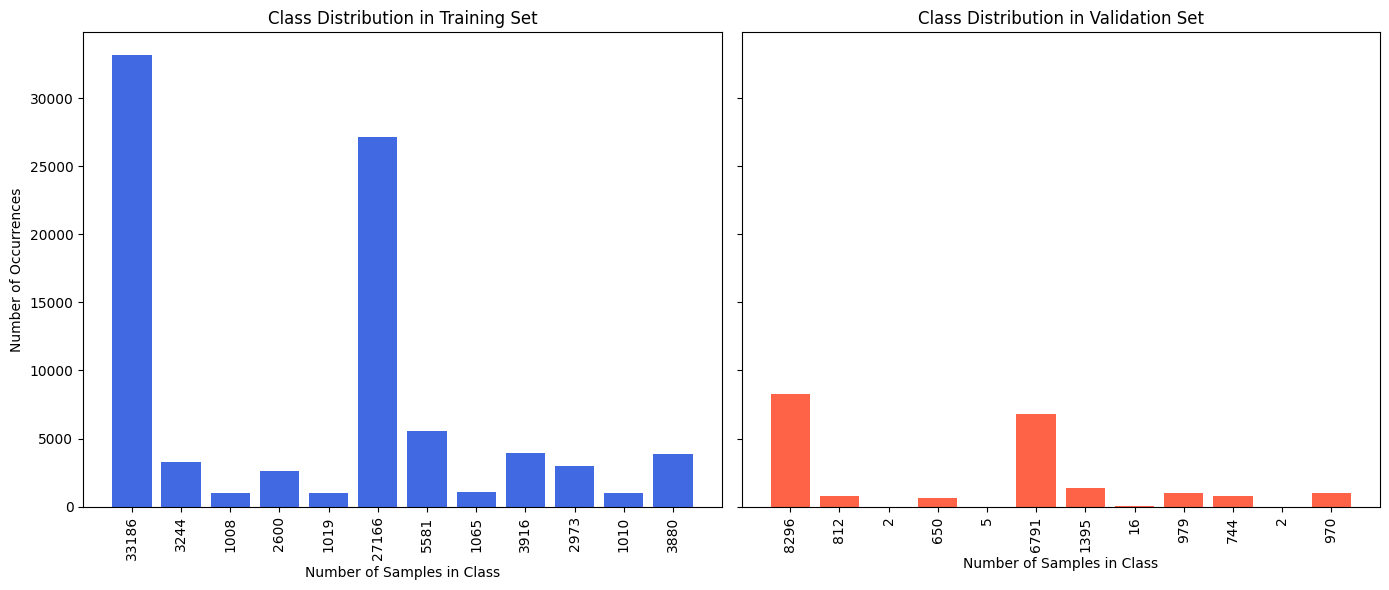

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class_labels = data_df.columns[2:]

train_class_counts = y_train.sum(axis=0)
val_class_counts = y_val.sum(axis=0)

x_train = np.arange(len(class_labels))
x_val = np.arange(len(class_labels))

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

axes[0].bar(x_train, train_class_counts, color='royalblue')
axes[0].set_xticks(x_train)
axes[0].set_xticklabels(train_class_counts, rotation=90)
axes[0].set_xlabel("Number of Samples in Class")
axes[0].set_ylabel("Number of Occurrences")
axes[0].set_title("Class Distribution in Training Set")

axes[1].bar(x_val, val_class_counts, color='tomato')
axes[1].set_xticks(x_val)
axes[1].set_xticklabels(val_class_counts, rotation=90)
axes[1].set_xlabel("Number of Samples in Class")
axes[1].set_title("Class Distribution in Validation Set")

plt.tight_layout()
plt.show()

In [ ]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

class TextDataset(Dataset):
    def __init__(self, X, y, max_length=None):
        input_ids = [torch.tensor(x["input_ids"], dtype=torch.long) for x in X]
        attention_mask = [torch.tensor(x["attention_mask"], dtype=torch.long) for x in X]
        self.max_length = max_length if max_length else max(len(ids) for ids in input_ids)
        self.input_ids = pad_sequence(input_ids, batch_first=True, padding_value=0)[:, :self.max_length]
        self.attention_mask = pad_sequence(attention_mask, batch_first=True, padding_value=0)[:, :self.max_length]

        y = np.array(y, dtype=np.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "labels": self.y[idx]
        }

y_train = np.array(y_train, dtype=np.float32)
y_val = np.array(y_val, dtype=np.float32)

train_dataset = TextDataset(X_train, y_train, max_length=256)
val_dataset = TextDataset(X_val, y_val, max_length=256)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

batch = next(iter(train_loader))

In [ ]:
print(batch["input_ids"].shape)
print(batch["attention_mask"].shape)
print(batch["labels"].shape)

torch.Size([16, 256])
torch.Size([16, 256])
torch.Size([16, 12])


# Model

In [ ]:
!pip install pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 931.6/931.6 kB 50.7 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
import pytorch_lightning as pl
from transformers import AutoModel
from torchmetrics.classification import MultilabelAccuracy

class Model(pl.LightningModule):
    def __init__(
        self,
        model_name: str = "airesearch/wangchanberta-base-att-spm-uncased",
        ckpt_path: str = None,
        learning_rate: float = 1e-5,
        freeze_encoder_weights: bool = False,
        num_labels: int = 12
    ):
        super().__init__()
        self.save_hyperparameters()

        self.encoder = AutoModel.from_pretrained(model_name)
        self.learning_rate = learning_rate

        if ckpt_path:
            checkpoint = torch.load(ckpt_path)
            encoder_state_dict = {
                k.replace("encoder.", ""): v for k, v in checkpoint["state_dict"].items() if k.startswith("encoder.")
            }
            self.encoder.load_state_dict(encoder_state_dict)

        self.linear_layer = nn.Linear(768, num_labels)

        if freeze_encoder_weights:
            self.freeze_weights(self.encoder)

        self.accuracy = MultilabelAccuracy(num_labels=num_labels, average="macro")
        self.loss_fn = nn.BCEWithLogitsLoss()

    def freeze_weights(self, model):
        for param in model.parameters():
            param.requires_grad = False

    def get_embeddings(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids, attention_mask)
        cls_embeddings = outputs.last_hidden_state[:, 0, :]
        return cls_embeddings

    def forward(self, input_ids, attention_mask):
        cls_embeddings = self.get_embeddings(input_ids, attention_mask)
        logits = self.linear_layer(cls_embeddings)
        return logits

    def step(self, batch, step_type: str):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"].float()

        logits = self.forward(input_ids, attention_mask)
        loss = self.loss_fn(logits, labels)
        self.log(f"{step_type}_loss", loss, prog_bar=True)

        preds = torch.sigmoid(logits)
        acc = self.accuracy(preds, labels)
        self.log(f"{step_type}_acc", acc, prog_bar=True)

        return loss

    def training_step(self, batch, batch_idx):
        return self.step(batch, "train")

    def validation_step(self, batch, batch_idx):
        return self.step(batch, "val")

    def test_step(self, batch, batch_idx):
        return self.step(batch, "test")

    def configure_optimizers(self):
        return AdamW(self.parameters(), lr=self.learning_rate)

model = Model(
    model_name="airesearch/wangchanberta-base-att-spm-uncased",
    ckpt_path=None,
    freeze_encoder_weights=False
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/423M [00:00<?, ?B/s]

Some weights of the model checkpoint at airesearch/wangchanberta-base-att-spm-uncased were not used when initializing CamembertModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing CamembertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# wandb_logger = WandbLogger(
#     project="DSDE-midterm",
#     name="wangchan_drop0.5_3epochs_augment_bs16nn_final",
#     log_model=True
# )

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor="val_acc",
    mode="max",
    save_top_k=1,
    save_weights_only=False,
    dirpath="./checkpoints/",
    filename="wangchan_drop0.5_3epochs_augment_bs16n_final",
    verbose=True,
)


trainer = Trainer(
    max_epochs=3,
    accelerator='auto',
    callbacks=[checkpoint_callback],
    gradient_clip_val=1.0,
    precision=16,
    # logger=wandb_logger,
    devices=1,
)

/usr/local/lib/python3.11/dist-packages/lightning_fabric/connector.py:572: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, train_loader, val_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type               | Params | Mode 
------------------------------------------------------------
0 | encoder      | CamembertModel     | 105 M  | eval 
1 | linear_layer | Linear             | 9.2 K  | train
2 | accuracy     | MultilabelAccuracy | 0      | train
3 | loss_fn      | BCEWithLogitsLoss  | 0      | train
------------------------------------------------------------
105 M     Trainable params
0         Non-trainable params
105 M     Total params
421.015   Total estimated model params size (MB)
3         Modules in train mode
228       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 8747: 'val_acc' reached 0.97793 (best 0.97793), saving model to '/content/checkpoints/wangchan_drop0.5_3epochs_augment_bs16n_final_lu5000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 17494: 'val_acc' reached 0.97845 (best 0.97845), saving model to '/content/checkpoints/wangchan_drop0.5_3epochs_augment_bs16n_final_lu5000.ckpt' as top 1


# Eval & Predict

In [ ]:
import torch
from transformers import AutoTokenizer

best_ckpt_path = "/content/checkpoints/wangchan_drop0.5_3epochs_augment_bs16n_final_lu5000.ckpt"
model = LMWithLinearClassifier.load_from_checkpoint(best_ckpt_path)
model.eval()

In [ ]:
class TestDataset(Dataset):
    def __init__(self, comments, tokenizer, max_length=256):
        self.comments = comments
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.comments)

    def __getitem__(self, idx):
        text = self.comments[idx]
        encoded = self.tokenizer(text, padding="max_length", truncation=True, max_length=self.max_length, return_tensors="pt")
        return {
            "input_ids": encoded["input_ids"].squeeze(0),
            "attention_mask": encoded["attention_mask"].squeeze(0)
        }

In [ ]:
import pandas as pd

# Load test data
test_df = pd.read_csv("/content/dataset/test.csv")

In [ ]:
#Clean test
test_df["comment"] = test_df["comment"].str.strip()
test_df["comment"] = test_df["comment"].str.lower()
test_df["comment"] = test_df["comment"].str.replace("\n", " ")
test_df["comment"] = test_df["comment"].str.replace("\r", " ")
test_df["comment"] = test_df["comment"].str.replace("\t", " ")
test_df["comment"] = test_df["comment"].apply(process_text)
test_df["comment"] = test_df["comment"].str.replace("ค่ะ", "")
test_df["comment"] = test_df["comment"].str.replace("ครับ", "")
test_df["comment"] = test_df["comment"].str.replace('ํา', "ำ")
test_df["comment"] = test_df["comment"].str.strip()

In [ ]:
print(test_df['comment'][1])
print("")
print(test_df['comment'][2])
print("")
print(test_df['comment'][3])
print("")
print(test_df['comment'][8])

In [ ]:
test_comments = test_df["comment"].tolist()
test_dataset = TestDataset(test_comments, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

predictions = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        logits = model(input_ids, attention_mask)
        preds = torch.sigmoid(logits)
        preds = (preds > 0.5).int()
        predictions.extend(preds.cpu().tolist())

output_df = pd.DataFrame(predictions, columns=[
    "สำนักงานตำรวจแห่งชาติ", "การรถไฟฟ้าขนส่งมวลชนแห่งประเทศไทย", "สภาเด็กและเยาวชนกรุงเทพมหานคร",
    "กรมควบคุมมลพิษ", "กรมสรรพสามิต", "การไฟฟ้านครหลวง", "กรมทางหลวง",
    "สำนักงานประกันสุขภาพแห่งชาติ", "การประปานครหลวง", "คณะกรรมการการพัฒนาเศรษฐกิจ",
    "กระทรวงการท่องเที่ยวและกีฬา", "สำนักงาน กสทช. ศูนย์รับแจ้งปัญหา 1200"
])

output_df.insert(0, "id", test_df["id"])

output_df.to_csv("predictions_wangchan_drop0.5_3epochs_augment_0.5_bs16nn_final_lu5000.csv", index=False)

print("Predictions saved")